# OpenStreetMap analysis
---

> **This analysis focuses on roads in the Netherlands that have physically separated bicycle paths nearby.**

# Section 1: Research Journey

## 1.1 Initial research question

> **~~Initial research question: “What is the impact of two valid modeling alternatives for representing physically separated cycleways?~~”

### 1.1.1 Mapping bicycle paths in OSM

> **Independent variable:**  Mapping approach  
>  
> - **Approach A:**  
> Cycleway = track as part of road  
> - **Approach B:**  
> Highway = cycleway separate

> **Dependent variables:**  
> Data quality metrics
>
> **Confounding factor to control**:
> Standalone vs part of a bicycle relation
>
> **Goal: Provide answer to which modeling approach is better?**
>
> Is it better to map physically separated bicycle paths as part of the road or as separate features?


![](osm_mapping_biccyle_paths.png)


In OpenStreetMap, many types of bicycle infrastructure allow **only a single valid mapping approach**. For example, roads with no bicycle infrastructure, roads where cyclists share lanes with motor vehicles, roads with dedicated bicycle lanes, or roads where bicycle lanes are shared with public transport must be mapped by **tagging the bicycle infrastructure as properties of the road itself**, as specified in the [OSM Wiki](https://wiki.openstreetmap.org/wiki/Key:cycleway).


An exception exists for roads with **physically separated bicycle paths**. In this case, two mapping approaches are considered equally valid: the bicycle path can either be mapped **as part of the road** (e.g. highway=* + cycleway=track) or **as a separate feature** (highway=cycleway). Unlike other cases, this requires OSM mappers to choose between **greater spatial detail** (mapping a separate object) or **simpler representation** (encoding the infrastructure on the road).

This duality introduces heterogeneity in the data that does not arise for other types of bicycle infrastructure.

### 1.1.2 Testing feasibility and why the research question was not pursued: unbalanced data 

> - Exploratory analysis showed that in the Netherlands, OSM contributors **overwhelmingly map physically separated bicycle paths as standalone features (highway=cycleway)** (~99%).
> 
> - As a result, highway=* + cycleway=track features represent only a tiny fraction of physically separated bicycle infrastructure.
> 
>- This extreme imbalance makes meaningful statistical comparison impossible.
>
> - **This imbalance is not specific to the Netherlands.**
>


**Original hypothesis:** The choice of mapping approach may affect the **completeness** and **consistency** of OSM data.

**Expected impact on completeness**

- If physically separated bicycle paths are mapped as standalone features, there is a risk that mappers might duplicate information both on the road and on the separate object, leading to overestimation in completeness metrics.
- If analyses consider only bicycle tags on roads and ignore standalone features, completeness could be underestimated.
- Mapping paths separately might encourage mappers to provide more detailed tags for bicycle infrastructure, whereas adding many bicycle tags to roads could discourage detail.

**Expected impact on consistency:**

- Mapping a physically separated path as a standalone object requires adding a tag on the road to indicate the separate mapping (cycleway=separate, bicycle=use_sidepath, or bicycle=optional_sidepath). If this tagging is missing, inconsistencies or errors may arise in interpreting the data.

**Initial goal:** 

Compare data quality metrics (completeness and consistency) between bicycle paths **physically separated from roads** that are mapped as standalone OSM objects (i.e. tagged with highway=cycleway) and those mapped as part of the road network (highway=* + cycleway=track).

For physically separated bicycle paths, the OSM community in the Netherlands appears to favor **greater spatial detail** by mapping them as standalone features. While this improves geometric representation, it introduces challenges for **maintaining consistency**, as consistency assessment can no longer rely on a single feature but must consider the **relationship between multiple features** (the road and the bicycle path).

**Issue identified:**

Exploratory analysis showed that in the Netherlands, OSM contributors overwhelmingly map bicycle paths that are physically separated from roads as **standalone features**. As a result, roads tagged with highway=* and cycleway=track represent only a small fraction of physically separated bicycle infrastructure, too small to support meaningful analysis. 

**Is this issue specific to the Netherlands?**
No

**Netherlands**

In [164]:
# way_bike_members_cycleway_track_stats = duckdb.sql("""
# WITH way_bike_members AS (
#     SELECT (osm_id || '/' || osm_type) AS parent_rel,
#             unnest(list_filter(members, x -> struct_extract(x, 'type') = 'way'), recursive := true) AS member
#     FROM read_parquet('/local/data/vbo226/my_dataset/latest/*.parquet')
#     WHERE osm_type = 'relation'
#       AND map_contains_entry(tags, 'type', 'route')
#       AND map_contains_entry(tags, 'route', 'bicycle')  
# ),
# way_bike_members_ids AS (
#     SELECT DISTINCT w.id AS osm_id
#     FROM way_bike_members w
# ),
# way_bike_members_unique AS (
# SELECT 
#     o.*,
#     ST_GeomFromWKB(geometry) AS geometry
# FROM way_bike_members_ids u
# INNER JOIN read_parquet('/local/data/vbo226/my_dataset/latest/*.parquet') o
#     ON u.osm_id = o.osm_id
#    AND o.osm_type = 'way'
# ),
# absolute_counts AS (
# SELECT
#     COUNT(*) as total_way_members, 
#     COUNT(CASE WHEN map_contains_entry(tags, 'cycleway', 'track') THEN 1 END) AS cycleway,
#     COUNT(CASE WHEN map_contains_entry(tags, 'cycleway:both', 'track') THEN 1 END) AS cycleway_both,
#     COUNT(CASE WHEN map_contains_entry(tags, 'cycleway:right', 'track') THEN 1 END) AS cycleway_right,
#     COUNT(CASE WHEN map_contains_entry(tags, 'cycleway:left', 'track') THEN 1 END) AS cycleway_left
# FROM way_bike_members_unique
# )
# SELECT
#     total_way_members,
#     cycleway,
#     cycleway_both,
#     cycleway_right,
#     cycleway_left,
#     cycleway * 1.0 / total_way_members *100 AS cycleway_rel,
#     cycleway_both * 1.0 / total_way_members *100 AS cycleway_both_rel,
#     cycleway_right * 1.0 / total_way_members * 100 AS cycleway_right_rel,
#     cycleway_left * 1.0 / total_way_members * 100 AS cycleway_left_rel
# FROM absolute_counts
# """).df()

# print(f"""Cycleways on ways that are part of bicycle routes:
# Total ways: {way_bike_members_cycleway_track_stats['total_way_members'][0]}
# Of these:
#   Cycleway both: {way_bike_members_cycleway_track_stats['cycleway_both'][0]} ({way_bike_members_cycleway_track_stats['cycleway_both_rel'][0]:.2f}%)
#   Cycleway right: {way_bike_members_cycleway_track_stats['cycleway_right'][0]} ({way_bike_members_cycleway_track_stats['cycleway_right_rel'][0]:.2f}%)
#   Cycleway left: {way_bike_members_cycleway_track_stats['cycleway_left'][0]} ({way_bike_members_cycleway_track_stats['cycleway_left_rel'][0]:.2f}%)
# """)

# way_bike_standalone_cycleway_track_stats = duckdb.sql("""
# WITH absolute_counts AS (
#     SELECT 
#         COUNT(*) AS total_ways,
#         COUNT(CASE WHEN map_contains_entry(tags, 'cycleway', 'track') THEN 1 END) AS cycleway,
#         COUNT(CASE WHEN map_contains_entry(tags, 'cycleway:both', 'track') THEN 1 END) AS cycleway_both,
#         COUNT(CASE WHEN map_contains_entry(tags, 'cycleway:right', 'track') THEN 1 END) AS cycleway_right,
#         COUNT(CASE WHEN map_contains_entry(tags, 'cycleway:left', 'track') THEN 1 END) AS cycleway_left
#     FROM read_parquet('/local/data/vbo226/my_dataset/latest/*.parquet')
#     WHERE osm_type = 'way'
#     AND map_contains(tags, 'highway')
# )
# SELECT
#         total_ways,
#         cycleway,
#         cycleway_both,
#         cycleway_right,
#         cycleway_left,
#         cycleway * 1.0 / total_ways * 100 AS cycleway_rel,
#         cycleway_both * 1.0 / total_ways * 100 AS cycleway_both_rel,
#         cycleway_right * 1.0 / total_ways * 100 AS cycleway_right_rel,
#         cycleway_left * 1.0 / total_ways * 100 AS cycleway_left_rel
#     FROM absolute_counts
# """).df()

# print(f"""Cycleways on standalone ways:
# Total ways: {way_bike_standalone_cycleway_track_stats['total_ways'][0]}
# Of these:
#   Cycleway=track both: {way_bike_standalone_cycleway_track_stats['cycleway_both'][0]} ({way_bike_standalone_cycleway_track_stats['cycleway_both_rel'][0]:.2f}%)
#   Cycleway right: {way_bike_standalone_cycleway_track_stats['cycleway_right'][0]} ({way_bike_standalone_cycleway_track_stats['cycleway_right_rel'][0]:.2f}%)
#   Cycleway left: {way_bike_standalone_cycleway_track_stats['cycleway_left'][0]} ({way_bike_standalone_cycleway_track_stats['cycleway_left_rel'][0]:.2f}%)
# """)

##### Belgium

In [165]:
# way_bike_members_cycleway_track_stats = duckdb.sql("""
# WITH way_bike_members AS (
#     SELECT (osm_id || '/' || osm_type) AS parent_rel,
#             unnest(list_filter(members, x -> struct_extract(x, 'type') = 'way'), recursive := true) AS member
#     FROM read_parquet('/local/data/vbo226/my_dataset/out_belgium/latest/*.parquet')
#     WHERE osm_type = 'relation'
#       AND map_contains_entry(tags, 'type', 'route')
#       AND map_contains_entry(tags, 'route', 'bicycle')  
# ),
# way_bike_members_ids AS (
#     SELECT DISTINCT w.id AS osm_id
#     FROM way_bike_members w
# ),
# way_bike_members_unique AS (
# SELECT 
#     o.*,
#     ST_GeomFromWKB(geometry) AS geometry
# FROM way_bike_members_ids u
# INNER JOIN read_parquet('/local/data/vbo226/my_dataset/out_belgium/latest/*.parquet') o
#     ON u.osm_id = o.osm_id
#    AND o.osm_type = 'way'
# ),
# absolute_counts AS (
# SELECT
#     COUNT(*) as total_way_members, 
#     COUNT(CASE WHEN map_contains_entry(tags, 'cycleway', 'track') THEN 1 END) AS cycleway,
#     COUNT(CASE WHEN map_contains_entry(tags, 'cycleway:both', 'track') THEN 1 END) AS cycleway_both,
#     COUNT(CASE WHEN map_contains_entry(tags, 'cycleway:right', 'track') THEN 1 END) AS cycleway_right,
#     COUNT(CASE WHEN map_contains_entry(tags, 'cycleway:left', 'track') THEN 1 END) AS cycleway_left
# FROM way_bike_members_unique
# )
# SELECT
#     total_way_members,
#     cycleway,
#     cycleway_both,
#     cycleway_right,
#     cycleway_left,
#     cycleway * 1.0 / total_way_members *100 AS cycleway_rel,
#     cycleway_both * 1.0 / total_way_members *100 AS cycleway_both_rel,
#     cycleway_right * 1.0 / total_way_members * 100 AS cycleway_right_rel,
#     cycleway_left * 1.0 / total_way_members * 100 AS cycleway_left_rel
# FROM absolute_counts
# """).df()

# print(f"""Cycleway=track on ways that are part of bicycle routes:
# Total ways: {way_bike_members_cycleway_track_stats['total_way_members'][0]}
# Of these:
#   Cycleway=track both: {way_bike_members_cycleway_track_stats['cycleway_both'][0]} ({way_bike_members_cycleway_track_stats['cycleway_both_rel'][0]:.2f}%)
#   Cycleway=track right: {way_bike_members_cycleway_track_stats['cycleway_right'][0]} ({way_bike_members_cycleway_track_stats['cycleway_right_rel'][0]:.2f}%)
#   Cycleway=track left: {way_bike_members_cycleway_track_stats['cycleway_left'][0]} ({way_bike_members_cycleway_track_stats['cycleway_left_rel'][0]:.2f}%)
# """)

# way_bike_standalone_cycleway_track_stats = duckdb.sql("""
# WITH absolute_counts AS (
#     SELECT 
#         COUNT(*) AS total_ways,
#         COUNT(CASE WHEN map_contains_entry(tags, 'cycleway', 'track') THEN 1 END) AS cycleway,
#         COUNT(CASE WHEN map_contains_entry(tags, 'cycleway:both', 'track') THEN 1 END) AS cycleway_both,
#         COUNT(CASE WHEN map_contains_entry(tags, 'cycleway:right', 'track') THEN 1 END) AS cycleway_right,
#         COUNT(CASE WHEN map_contains_entry(tags, 'cycleway:left', 'track') THEN 1 END) AS cycleway_left
#     FROM read_parquet('/local/data/vbo226/my_dataset/out_belgium/latest/*.parquet')
#     WHERE osm_type = 'way'
#     AND map_contains(tags, 'highway')
# )
# SELECT
#         total_ways,
#         cycleway,
#         cycleway_both,
#         cycleway_right,
#         cycleway_left,
#         cycleway * 1.0 / total_ways * 100 AS cycleway_rel,
#         cycleway_both * 1.0 / total_ways * 100 AS cycleway_both_rel,
#         cycleway_right * 1.0 / total_ways * 100 AS cycleway_right_rel,
#         cycleway_left * 1.0 / total_ways * 100 AS cycleway_left_rel
#     FROM absolute_counts
# """).df()

# print(f"""Cycleways=track on standalone ways:
# Total ways: {way_bike_standalone_cycleway_track_stats['total_ways'][0]}
# Of these:
#   Cycleway=track both: {way_bike_standalone_cycleway_track_stats['cycleway_both'][0]} ({way_bike_standalone_cycleway_track_stats['cycleway_both_rel'][0]:.2f}%)
#   Cycleway=track right: {way_bike_standalone_cycleway_track_stats['cycleway_right'][0]} ({way_bike_standalone_cycleway_track_stats['cycleway_right_rel'][0]:.2f}%)
#   Cycleway=track left: {way_bike_standalone_cycleway_track_stats['cycleway_left'][0]} ({way_bike_standalone_cycleway_track_stats['cycleway_left_rel'][0]:.2f}%)
# """)

## 1.2. New research question

> **Original focus**:
> Compare two mapping approaches for physically separated bicycle >paths: as part of the road (cycleway=track) versus standalone 
> (highway=cycleway) and assess completeness and consistency.

> **New focus**
> Assess relational **consistency** of standalone bicycle paths (highway=cycleway), examining whether they are correctly represented in **relation to adjacent roads** (cycleway=separate) or included in cycle relations.
>
> **Data quality indicator**
> Consistency (% road tagged with `cycleway=separate`, `bicycle=use_sidepath`, or `bicycle=optional_sidepath`) that have nearby highway=cycleway
> 
> **Data quality operationalization:**
> **Consistency:** Tested whether roads tagged `cycleway=separate`, `bicycle=use_sidepath`, or `bicycle=optional_sidepath` have a nearby highway=cycleway feature, as is should be expected.
>
> **Research question**: “To what extent do roads tagged with cycleway=separate (or biycle=use_sidepath or bicycle=optional_sidepath) and their associated highway=cycleway features correctly and consistently represent physically separated bicycle paths, both as standalone features and as part of cycle relations?”**
>
>**Goal**: Directly addresses relational data quality challenges, where correctness depends on the relationship between multiple OSM objects, not on tags on a single object. Enables identification of inconsistencies and incompleteness that affect real-world applications of OSM bicycle data.


### 1.2.1 Single-object data quality vs multi-object quality
---

> **Single-object quality:**
>
> - Some data quality metrics can be evaluated by looking at one object in isolation.
> - Example: A road tagged highway=motorway should not have bicycle=yes.
> - These metrics are fully assessable without considering surrounding objects.
>
> **Multi-object quality:**
> - Certain quality issues **only emerge when examining relationships between multiple objects.**
> - Example: If a physically separated bicycle path runs alongside a road:
>  > - The bicycle path should be tagged highway=cycleway
>  > - The adjacent road should be tagged cycleway=separate
>  >
>  > 
>  Neither object alone is “wrong”:
>  >
>  > - A highway=cycleway is valid by itself
>  > - A road without cycleway=separate is also valid by itself
>  > 
> **The quality issue only becomes visible when both objects are considered together.**

## 1.2.2 Change in research focus: consistency between related objects
---

**New focus:** bicycle paths mapped as standalone features (highway=cycleway), which make up the majority of bicycle paths in the Netherlands. As a result, the new focus moved to to assessing how completeness and  consistency vary depending on whether these features are part of relations or mapped in isolation. This approach directly addresses data quality challenges that arise when real-world infrastructure is **represented through relationships between multiple OSM features**, rather than through tags on a single object (which is the case for _some_ bicycle infrastructure tagged as highway=cycleway).

Given the limitations identified in the initial analysis, the research focus was adjusted. Instead of comparing bicycle paths mapped on roads (highway=*, cycleway=track) versus standalone features (highway=cycleway), the analysis shifted to examining **differences in  consistency between bicycle infrastructure that is part of bicycle relations and infrastructure that is not**.

**Consistency** was evaluated by testing whether roads tagged with cycleway=separate or bicycle=use_sidepath or bicycle=optional_sidepath have a nearby feature tagged highway=cycleway, as expected when a physically separated bicycle path is mapped independently.

# Overview
---

**Overview tables:**

How to interpret the variables in the table:
1. **osm_type**(rel, way, node)
   - Tells **what each row represents**
2. **domain**
   - Indicates which **subset of OSM features the table represents**
   - `bike` -> bicycle-related features
   - `road` -> general road network features (**excluding** features already classified as bicycle-related infrastructure)
3. **membership/hierarchy**
   - Highlights **how features relate within the OSM hierarchy**
   - `member` -> a feature that is part of a relation
   - `standalone` -> a feature not part of any relation
4. **grid inersection**
    - 'grid_intersects'
5. **spatial proximity**
   'near' 

|**Table name**|**Description**|**Derived from/subset of**|
|:------:|:------:|:------:|
|`osm_data`| All OSM features (**nodes, ways, and relations**) contained in the ohsome planet file for the AOI.| - | 
|`rel_bike_routes`|All OSM **relations** tagged with type=route and route=bicycle. These relations define what is referred to as bicycle relations in this analysis. Information about members is limited to what provided in the _members_ column| `osm_data` → filter relations |
|`way_bike_members`| Subset of `rel_bike_routes` containing only **way members, unnested** so each row is a way-relation pair. The same way can appear multiple times if it belongs to multiple relations.| `osm_data` → `rel_bike_routes` → unnest way members| 
|`node_bike_members`| Subset of `rel_bike_routes` containing only **node members, unnested** so each row is a node-relation pair. The same node can appear multiple times if it belongs to multiple relations.| `osm_data` → `rel_bike_routes` → unnest node members|
| | |
|`way_bike_members_unique`| All **unique ways** from way_bike_members. Deduplicated so each way appears only once, includes full way-level attributes (beyond _members column information).| `osm_data` → `rel_bike_routes` → `way_bike_members` → deduplicate|
|`way_bike_standalone`| All ways with bicycle-related tags (user-defined) that **are not part of any bicycle relation**. Represents standalone parts of the bicycle network.| `osm_data` → filter ways |
|`way_bike_network`| Union of `way_bike_members_unique` and `way_bike_standalone`. Represents the **complete bicycle infrastructure network** in the AOI. | `way_bike_members_unique` + `way_bike_standalone` |
| | |
|`way_road_nonbike`|All ways tagged with highway=* that are **not part of** `way_bike_network`. Represents the general road network without dedicated bicycle facilities.| `osm_data` → filter ways → exclude bike network | 
|`way_road_nonbike_cycleway_separate`| Subset of way_road_nonbike tagged with at least one of: cycleway=separate, bicycle=use_sidepath, or bicycle=optional_sidepath. These are **roads expected to have a nearby cycleway**.| `way_road_nonbike` → filter by bicycle / cycleway tags | 
|`grid_way_bike_members_unique_intersects`|All unique bicycle-network ways that are members of bicycle relations (`way_bike_members_unique`) intersecting each grid cell.|`grid` → intersect with `way_bike_members_unique`|
|`grid_way_bike_standalone_intersects`|All standalone bicycle ways (`way_bike_standalone`) intersecting each grid cell.|`grid` → intersect with `way_bike_standalone`|
|`grid_way_bike_members_unique_intersects_highway_cycleway`|Subset of `grid_way_bike_members_unique_intersects` containing **only ways tagged with highway=cycleway**.|`grid_way_bike_members_unique_intersects` → filter highway=cycleway|
|`grid_way_bike_standalone_intersects_highway_cycleway`|Subset of `grid_way_bike_standalone_intersects` containing **only ways tagged with highway=cycleway**.|`grid_way_bike_standalone_intersects` → filter highway=cycleway|
|`grid_way_road_non_bike_intersects`|All road ways (way_road_nonbike) intersecting each grid cell.|`grid` → intersect with `way_road_nonbike`|
|`grid_way_road_non_bike_cycleway_separate_intersects`|Subset of `grid_way_road_non_bike_intersects` containing **only roads tagged with cycleway=separate, bicycle=use_sidepath, or bicycle=optional_sidepath**|`grid_way_road_non_bike_intersects` → filter by bicycle / cycleway tags|
|**`road_near_bike_members`**|All roads tagged with cycleway=separate, bicycle=use_sidepath, bicycle=optional_sidepath (`grid_way_road_non_bike_cycleway_separate_intersects`) that are **nearby** a highway=cycleway (part of bicycle relations)|`grid_way_road_non_bike_cycleway_separate_intersects` → spatial proximity to `grid_way_bike_members_unique_intersects_highway_cycleway`|
|**`road_near_bike_standalone`**|All roads tagged with cycleway=separate, bicycle=use_sidepath, bicycle=optional_sidepath (`grid_way_road_non_bike_cycleway_separate_intersects`) that are **nearby** a highway=cycleway (standalone)|`grid_way_road_non_bike_cycleway_separate_intersects` → spatial proximity to `grid_way_bike_standalone_intersects_highway_cycleway`|


# Setup
---

In [166]:
#kernel check
import sys
print(sys.executable)

/local/data/vbo226/duckdb_py312/bin/python


In [167]:
#pip install duckdb lonboard pyarrow geopandas palettable matplotlib

In [168]:
import duckdb
from lonboard import viz, PathLayer, PolygonLayer, ScatterplotLayer, Map
from lonboard.basemap import CartoBasemap
from lonboard.colormap import apply_continuous_cmap
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely import wkt
from IPython.display import HTML, display

In [169]:
duckdb.sql("INSTALL spatial; LOAD spatial")

# Section 2: Split AOI into grid cells: assign data to grid

---

**Challenge:** Running queries (especially involving spatial joins) on big data causes computer to crash. 

**Solution**: Partition the AOI into grids. Later on, assign data to grid cells. Run queries on data from one grid cell at a time. Repeat for all grid cells. Combine results. 

To partition space into smaller regions, it is necessary to
- Define the **extent** of the area to be subdivided
- Define the **shape** and the **dimension** of the sub-regions to be created

### 2.1 Define the extent for the partition
---

#### 2.1.1 Get administrative boundary of the Netherlands

The Area of Interest (AOI) of this analysis is the **Netherlands**, excluding the 6 overseas islands in the Carribean part of the Kingdom of the Netherlands. 

The administrative boundaries of the Netherlands were accessed from the [GADM](https://gadm.org/) website. The GADM dataset provides spatial data about administrative country boundaries. 
The data's coordinate reference system is **'OGC:CRS84'**, essentially 'EPSG:4326' but with axis order **lon/lat**. 

*Note: The DuckDB httpfs extension could not be used to read the file remotely, as it does not correctly detect geometry columns in this dataset. 

Regardless of which shape or size is chosen for the partition, sub-regions are always easier to be created (mathematically speaking) when the extent represents the **minimum bounding box** of the AOI, instead of the administrative boundaries of the AOI itself. 
For this reason, the **extent of the partition will be defined as the minimum bounding bounding box of the AOI**  

<!-- 
The `ST_Extent()` function will be used as opposed to `ST_Envelope()` because it returns the minimum bounding box of the AOI as a BOX_2D data type, which is a DuckDB native spatial data type. As a DuckDB spatial data type, it does not comply with the OGC Simple Feature specification, however, it is optimized to make queries in DuckDB more efficient. 
The perfomance gains are negligible when dealing with a single country, however, with the vision of extending the analysis to the world, `ST_Extent()` should be preferred. -->

#### 2.1.2 Set variable: define AOI and visualize the extent of the AOI 

In [170]:
#Specify the country alpha-3 iso code of your AOI 

aoi_iso3 = 'NLD'

In [171]:
#Retrieve and visualize the administrative country-level boundary of the AOI
aoi = duckdb.sql(f"""SELECT *
FROM st_read('https://geodata.ucdavis.edu/gadm/gadm4.1/json/gadm41_{aoi_iso3}_0.json')
""")

aoi.show(max_width=100)

print('Country-level administrative boundaries of AOI:')
viz(aoi)

┌─────────┬─────────────┬──────────────────────────────────────────────────────────────────────────┐
│  GID_0  │   COUNTRY   │                                   geom                                   │
│ varchar │   varchar   │                                 geometry                                 │
├─────────┼─────────────┼──────────────────────────────────────────────────────────────────────────┤
│ NLD     │ Netherlands │ MULTIPOLYGON (((6.0071 50.7566, 5.9866 50.7578, 5.9596 50.7621, 5.9047…  │
└─────────┴─────────────┴──────────────────────────────────────────────────────────────────────────┘

Country-level administrative boundaries of AOI:


/local/data/vbo226/duckdb_py312/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:40: UserWarning: No CRS exists on data. If no data is shown on the map, double check that your CRS is WGS84.
  warn(


In [172]:
#Extract the minimum bounding box of the AOI
nl_bbox = duckdb.sql(f"""SELECT ST_Envelope(geom) as bbox
FROM st_read('https://geodata.ucdavis.edu/gadm/gadm4.1/json/gadm41_{aoi_iso3}_0.json')
""")

nl_bbox.show(max_width=100)

print('Minimum bounding box of AOI:')
viz(nl_bbox)

┌──────────────────────────────────────────────────────────────────────────────────────────┐
│                                           bbox                                           │
│                                         geometry                                         │
├──────────────────────────────────────────────────────────────────────────────────────────┤
│ POLYGON ((3.3608 50.7235, 7.227 50.7235, 7.227 53.5546, 3.3608 53.5546, 3.3608 50.7235)) │
└──────────────────────────────────────────────────────────────────────────────────────────┘

Minimum bounding box of AOI:


### 2.2. Define the sub-regions for the partition
---

Potentially, the extent of the AOI could be subdivided into sub-regions of different shapes and sizes. However, summarizing information using **regions of the same shape and size should be preferred**. 

#### 2.2.1 Define the _shape_ of the sub-regions for the partition

---

> **Sub-regions should be identical in shape**

The main reason why sub-regions of different shapes should be avoided is that **relationships with neighbor sub-regions** are not uniform. This means that the way a feature in one sub-region interacts with features in adjacent sub-regions should follow the same rules across the entire area.

The main reason is that **relationships with neighboring sub-regions must be consistent**. 

For example, in a square grid, each square has **4 main neighbors** (up, down, left, right). A line crossing a square can only move into one of these 4 neighbors, making the interaction predictable and easy to calculate.

If sub-regions have different shapes, features will interact differently across regions, making analysis unpredictable.

Maintaining consistent shapes simplifies spatial analysis and ensures consistency across the AOI.

> Sub-regions should be **regular shapes**

#### 2.2.2 Which shapes to use?

Only three types of regular shapes allow covering the the entire Earth surface without gaps or overlaps. Those shapes are: **squares, hexagons and equilateral triangles**. These shapes are the only ones that can perfectly tile a plane.

While our analysis focuses on the Netherlands and does not require global tiling, choosing one of these shapes is advantageous if the workflow might later scale to a worldwide level.

For very small areas, irregular shapes can work fine, as any gaps would likely be negligible.

However, tiling problems usually arise when extending a pattern over larger surfaces, because irregular shapes rarely tessellate perfectly. 

**Partition AOI into smaller regions: grid, hexagons or triangles?**

-**Grid (squares)** 
- Simple to construct and implement. 
- Neighbor relationships are straightforward
- Hierarchical splitting is possible and customizable, allowing flexible aggregation and multi-resolution analysis.

**Hexagons**
- Preferred for distance-based analyses, as all 6 neighbors are equidistant from the center.
- Hierarchical relationships are less intuitive, though tools like H3 can simplify this.
- Custom resolution is limited compared to grids due to predefined H3 levels.
  
**Triangles**
- Rarely used for general spatial partitioning
- Neighbor relationships and hierarchical splitting are more complex than grids or hexagons.

**Conclusion: Grid partition was chosen**
A grid-based partitioning was chosen because the analysis is not distance-focused, making the primary advantage of hexagons irrelevant. Grids offer flexibility in splitting and aggregation, and their resolution can be customized as needed, unlike hexagons with fixed hierarchical levels. Triangles were not considered further due to their complexity and limited applicability for this type of analysis.
Although the sub-regions in this workflow are currently defined using a grid, the approach is flexible and can be easily adapted to use hexagonal cells instead.

> **Decision block:** defining sub-regions with a **grid**

#### 2.2.3 Define the _size_ of the sub-regions for the partition

> Sub-regions should have **equal area**

The research question at the end is a question quantify the **density of errors in OSM** and to allow comparisons between regions, **area** is a critical component of these measures.

The same statistical measures calculated over areas of different sizes might change the interpretation of a phenomenon completely. This is known as the **Modifiable Areal Unit Problem**. 

Fo example:
- 100,000 people living in an an area 20,000 km2 would make the space feel spacious 
- 100,000 people living in an area of 5,000 km2 would make the space feel crowded 

The same would be the case
- 1,000 errors detected in OSM over an area of 20,000 km2 would be interpreted as that area having bad data quality
- 1,000 errors detected in OSM over an area of 5,000 km2 would be interpreted as that area having good data quality

**For density measures to be comparable, the area used to calculate them has to be the same**. Otherwise, additional normalization by area would be required. Using a grid of equally sized sub-regions avoids this extra step.

**Choosing the dimension of the sub-regions** 

In the analysis, the **dimension** of the sub-regions was determined purely for **computation purposes**. The AOI was subdivided into sub-regions small enough for queries to run without causing the computer to crash and yet large enough to avoid excessive processing time when looping through all queries.

#### 2.2.4 Role of projections to satisfy equal area sub-regions

> An **equal-area projection** should be used. Since the AOI is the Netherlands, the [**EPSG:3035 (ETRS89 / LAEA Europe)**](https://spatialreference.org/ref/epsg/3035/) equal-area projection was used. Maintains true area, minimal distortion over continental Europe.

**Methodological requirement:** sub-regions must be equal in area 

If one creates a grid in EPSG:3857, the cell grids might look equal, however, in real life, it would actually not be the case.

#### What if I used 'EPSG:3857'?
---

Although a regular grid in EPSG:3857 might visually appear uniform, this projection is cylindrical and conformal, meaning it preserves shapes locally but distorts areas with latitude. To illustrate this, a test query was run:

1. A global grid of squares was generated in EPSG:3857. EPSG3857 world extent derived from the [epsg website](https://epsg.io/3857)
2. Each square was transformed to EPSG:4326 (geographic coordinates).
3. The true area of each grid cell was calculated using ST_Area_Spheroid().
4. Visualizing the areas with a colormap shows clear variation: cells near the poles cover much less or more area than those near the equator.

This demonstrates that simply creating squares in EPSG:3857 does not satisfy the equal-area requirement, and highlights the importance of using proper equal-area

In [173]:
world_grid_df = duckdb.sql("""
WITH world_bbox AS (
SELECT ST_MakeEnvelope(min_x := -20037508.34, min_y := -20048966.1, max_x := 20037508.34, max_y := 20048966.1) as bbox
),
world_bbox_coords AS (
    SELECT 
        CEIL(ST_XMin(bbox))::BIGINT as xmin,
        CEIL(ST_YMin(bbox))::BIGINT as ymin,
        CEIL(ST_XMax(bbox))::BIGINT as xmax,
        CEIL(ST_YMax(bbox))::BIGINT as ymax
    FROM world_bbox
),
world_grid AS (
SELECT 
    row_number() over() as grid_id, 
    ST_Transform(ST_MakeEnvelope(xv, yv, xv + 1000000, yv + 1000000), 'EPSG:3857', 'EPSG:4326', TRUE) AS grid_cell
FROM world_bbox_coords
CROSS JOIN LATERAL generate_series(xmin, xmax, 1000000) AS gx(xv)
CROSS JOIN LATERAL generate_series(ymin, ymax, 1000000) AS gy(yv)
)
SELECT grid_id,
    ST_AsText(grid_cell) as grid_cell,
    ST_Area_Spheroid(grid_cell) as area_m2
FROM world_grid
""").df()

world_grid_gdf = gpd.GeoDataFrame(world_grid_df, geometry=world_grid_df["grid_cell"].apply(wkt.loads), crs="EPSG:4326")

world_grid_gdf_nonan = world_grid_gdf.dropna(subset=["area_m2"])

cmap_values = world_grid_gdf_nonan['area_m2']

cmap_values_norm = (cmap_values - cmap_values.min()) / (cmap_values.max() - cmap_values.min())

cmap = plt.get_cmap("viridis") 
cmap

world_grid_layer = PolygonLayer.from_geopandas(world_grid_gdf_nonan, get_fill_color = apply_continuous_cmap(cmap_values_norm, cmap=cmap), get_line_width=1, get_line_color='black', line_width_units='common', visible=True)

Map(world_grid_layer)

For this reason, an **equal area projection** should be chosen. An equal area projection preserves area. As a result, 1 km2 sub-region on the map would correspond to 1km2 sub-region in real life, **regardless of latitude**. 

Using an equal-area projection ensures that all sub-regions truly have the same area, providing a consistent denominator for density calculations.

#### 2.2.5 Set variable: define size of sub-regions
---

In [174]:
set_grid_size = 10000

The grid cell size in this analysis was set at **10,000 meters, corresponding to an area of 10x10 km2**. 

This size provided a good balance for computational efficiency: cells were large enough to avoid excessive looping, but not so large that they contained too much data. The primary goal of the partitioning was to optimize computation and visualization performance. The grid size will also be varied in additional tests to assess whether the results are robust to changes in sub-region dimensions.

#### 2.2.6 Construct grid
---

In [175]:
grid = duckdb.sql(f"""
--**CREATION OF SQUARE GRID**
--Define NL bbox 
WITH NL_bbox AS (
    SELECT ST_Transform(bbox, 'EPSG:4326', 'EPSG:3035', TRUE) as bbox --Get bbox encloding NL administrative boundary. Transform coordinates from 4326 (original) to 3857 (with units meters)
    FROM nl_bbox
), 
-- Retrieve minx, miny, maxx, maxy coordinates NL bbox
NL_coords AS (
    SELECT 
        CEIL(ST_XMin(bbox))::BIGINT as xmin, --cast coordinates from DOUBLE to BIGINT because generate_series() function requires BIGINT
        CEIL(ST_YMin(bbox))::BIGINT as ymin,
        CEIL(ST_XMax(bbox))::BIGINT as xmax,
        CEIL(ST_YMax(bbox))::BIGINT as ymax
    FROM NL_bbox
)
--Create a made up a grid of squares of cell size 50,000* 50,000
SELECT 
    row_number() over() as grid_id, 
    ST_Transform(ST_MakeEnvelope(xv, yv, xv + {set_grid_size}, yv + {set_grid_size}), 'EPSG:3035', 'EPSG:4326', TRUE) AS grid_cell
FROM NL_coords
CROSS JOIN LATERAL generate_series(xmin, xmax, {set_grid_size}) AS gx(xv)
CROSS JOIN LATERAL generate_series(ymin, ymax, {set_grid_size}) AS gy(yv);
""")

##### 2.2.6.1 Query explained
---

To generate a grid over an AOI, there are three crucial elements: 
1. define AOI;
2. define grid cell size

The Area Of Interest is the Netherlands. The administrative boundaries of the Netherlands were downloaded from the GADM website. 
The easiest way to create a grid over an area is for this area to be a square. This because just by specifying the bottom-left and top-right corner, it is possible to create evenly spaced grid. 

The [GADM](https://gadm.org/) dataset provides spatial data about administrative country boundaries. 
The data's coordinate reference system is 'OGC:CRS84', essentially 'EPSG:4326' but with axis order **lon/lat**. 

To generate a grid over an AOI, it is necessary to specify the desired grid cell size (i.e. the distance between two consecutive points). 
With data in 'OGC:CRS84', the ST_Transform() function would have interpreted the distance (e.g. 100,000 m) to be in degrees (i.e. 100, 000 degrees). 
To avoid this problem, it is necessary to first reproject GADM's data into a metric coordinate system (e.g. 'EPSG:3035'). 

CROSS LATERAL JOIN together with generate_series() was used to create a series of points at a fixed distance from each other. 

Ultimately, the data was reprojected again to 'EPSG:4326' for visualization purposes. Lonboard does not yet support visualizing data in a different CRS than 'EPSG:4326'.

In [176]:
grid_layer = PolygonLayer.from_duckdb(grid, filled=True, get_fill_color='white', get_line_width=0.02, get_line_color='white', line_width_units='common', opacity=0.01, pickable=True, visible=True)

Map(grid_layer, basemap_style=CartoBasemap.DarkMatter)

/local/data/vbo226/duckdb_py312/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:40: UserWarning: No CRS exists on data. If no data is shown on the map, double check that your CRS is WGS84.
  warn(
/tmp/ipykernel_706/863115411.py:3: DeprecationWarning: `basemap_style` is deprecated and will be removed in 0.14. Use `basemap` instead.
  Map(grid_layer, basemap_style=CartoBasemap.DarkMatter)


### 2.3. Alternative: partition AOI using hexagonal grid
---

Using the DuckDB H3 extension, it is possible to easily create a hexagonal spatial grid for this workflow. 

In [177]:
duckdb.sql("INSTALL h3 FROM community; LOAD h3")

h3_cells = duckdb.sql("""
WITH h3_ids AS (
SELECT h3_polygon_wkt_to_cells(ST_AsText(bbox), 5) AS h3_id
FROM nl_bbox
)
SELECT h3_id,
    h3_cells_to_multi_polygon_wkt(h3_id)::GEOMETRY AS h3_cells
FROM h3_ids
""")

viz(h3_cells)

# Section 3: Quick overview of `osm_data`
---

## 3.1 Define variable: ohsome-planet _latest_ file 
---

In [178]:
osm_data = '/local/data/vbo226/my_dataset/latest/*.parquet'  

In [179]:
osm_data_stats = duckdb.sql("""
WITH absolute_counts AS (
    SELECT
        COUNT(*) AS total,
        COUNT(CASE WHEN osm_type = 'node' THEN 1 END) AS count_node,
        COUNT(CASE WHEN osm_type = 'way' THEN 1 END) AS count_way,
        COUNT(CASE WHEN osm_type = 'relation' THEN 1 END) AS count_relation
    FROM read_parquet('/local/data/vbo226/my_dataset/latest/*.parquet') AS osm_data
)
SELECT
    total,
    count_node,
    count_way,
    count_relation,
    count_node * 1.0 / total * 100 AS pct_node,
    count_way * 1.0 / total * 100 AS pct_way,
    count_relation * 1.0 / total * 100 AS pct_relation
FROM absolute_counts
""").df()

print(f"""
OSM dataset summary:
- Total elements: {osm_data_stats['total'][0]:,}
- Nodes: {osm_data_stats['count_node'][0]:,} ({osm_data_stats['pct_node'][0]:.2f}% of total)
- Ways: {osm_data_stats['count_way'][0]:,} ({osm_data_stats['pct_way'][0]:.2f}% of total)
- Relations: {osm_data_stats['count_relation'][0]:,} ({osm_data_stats['pct_relation'][0]:.2f}% of total)
""")


OSM dataset summary:
- Total elements: 32,282,004
- Nodes: 14,117,347 (43.73% of total)
- Ways: 17,962,333 (55.64% of total)
- Relations: 202,324 (0.63% of total)



# Section 4: bicycle infrastructure from bicycle route relations
---

**Purpose:**
Part of the OSM bicycle infrastructure is modeled via route relations. This section extracts the **way-level geometry** from those relations.

## 4.1: Bicycle route relations
---

In OpenStreetMap, bicycle route relations can be modeled in two ways: 
- **Standard bicycle route relations**
- **Node network bicycle route relations** 

The prevalence of these models varies geographically.
In many countries, bicycle routes are predominantly mapped as standard route relations, while in others, a node network model is prevalent (e.g. Netherlands, Germany). Some regions exhibit a mixture of both approaches (Germany, France).

Within the area of interest (AOI) of this analysis, prior exploratory analysis has shown that **the majority of bicycle route relations follow the node network model and exhibit high tag completeness**. Specifically, the vast majority of relations tagged with type=route and route=bicycle in the AOI also include all tags required for node network bicycle routes:

- type = route
- route = bicycle
- network:type = node_network
- network = *
- ref = *

Despite the expectation that bicycle routes in the AOI are modeled as node networks, bicycle route relations were identified using only the minimal identification tags:

**What is this object?**
- type = route
- route = bicycle

**These tags define the object as a bicycle route relation, independent of the specific modeling approach used.**

This choice ensures that the selection is **as inclusive as possible** and avoids excluding valid bicycle routes due to missing or 
inconsistently applied modeling tags. Although the selection criteria are deliberately broad, initial exploratory analysis confirms that this inclusiveness does not compromise data quality: the resulting dataset is effectively equivalent to one selected using stricter node network tagging, but without the risk of excluding valid routes due to tagging inconsistencies.

**As a result, the selected dataset reliably represents the intended node network bicycle routes**, while remaining robust to potential tagging inconsistencies and transferable to regions where different modeling approaches coexist.

### 4.1.1 **Decision block: what counts as a bicycle route relation?**

> All relations tagged with **type=route AND route=bicycle**

### 4.1.2 About the rel_bike_routes table
---

Each row in the `rel_bike_routes table` represents one OSM relation, defined by the tags:
- osm_type = relation
- type = route
- route = bicycle

A relation consists of **one or more members**, which can be:
- Ways
- Nodes
- Relations

Information about relation members is stored in the **members column**.

- A single relation can have multiple members
- **A single member (way or node) can belong to multiple relations**

In [180]:
rel_bike_routes = duckdb.sql("""
SELECT *
FROM read_parquet('/local/data/vbo226/my_dataset/latest/*.parquet')
WHERE 1=1
AND osm_type = 'relation'
AND map_contains_entry(tags, 'type', 'route')
AND map_contains_entry(tags, 'route', 'bicycle')
""")

rel_bike_routes.show(max_width=100)

┌─────────┬──────────────────────┬───┬──────────────────────┬───────────┬────────────┐
│ status  │      valid_from      │ … │       members        │ countries │ build_time │
│ varchar │ timestamp with tim…  │   │ struct("type" varc…  │ varchar[] │   int64    │
├─────────┼──────────────────────┼───┼──────────────────────┼───────────┼────────────┤
│ latest  │ 2022-12-17 12:33:2…  │ … │ [{'type': way, 'id…  │ []        │      15000 │
│ latest  │ 2024-11-07 16:09:5…  │ … │ [{'type': way, 'id…  │ []        │      20500 │
│ latest  │ 2022-04-28 22:27:0…  │ … │ [{'type': way, 'id…  │ []        │       9900 │
│ latest  │ 2022-06-05 12:32:0…  │ … │ [{'type': way, 'id…  │ []        │      16000 │
│ latest  │ 2020-11-22 19:34:1…  │ … │ [{'type': way, 'id…  │ []        │      32800 │
│ latest  │ 2025-04-17 19:35:1…  │ … │ [{'type': way, 'id…  │ []        │      14700 │
│ latest  │ 2025-04-15 17:40:1…  │ … │ [{'type': way, 'id…  │ []        │      12900 │
│ latest  │ 2020-11-24 08:35:5…  │ … │ [{'t

In [181]:
rel_bike_stats = duckdb.sql("""
WITH absolute_counts AS (
SELECT 
    COUNT(*) as count_rel,
    SUM(list_count(members)) as count_members,
    SUM(list_count(list_filter(members, x -> struct_extract(x, 'type') = 'way')))::INT as count_way_members,
    SUM(list_count(list_filter(members, x -> struct_extract(x, 'type') = 'node')))::INT as count_node_members
FROM rel_bike_routes
)
SELECT 
    count_rel,
    count_members,
    count_way_members,
    count_node_members,
--Calculate relative_frequencies
    count_way_members * 1.0 / count_members * 100 as rel_freq_way_members,
    count_node_members/count_members as rel_freq_node_members
FROM absolute_counts
""").df()

print(f"""
Total bicycle route relations: {rel_bike_stats['count_rel'][0]:,} 

Total members: {rel_bike_stats['count_members'][0]:,} 

Total way members: {rel_bike_stats['count_way_members'][0]:,} ({rel_bike_stats['rel_freq_way_members'][0]:.2f}%)
Total node members: {rel_bike_stats['count_node_members'][0]:,} ({rel_bike_stats['rel_freq_node_members'][0]:.2f}%)
""")


Total bicycle route relations: 17,375 

Total members: 303,205.0 

Total way members: 301,162 (99.33%)
Total node members: 2,033 (0.01%)



**Most members of bicycle relations represent linear features, as expected for route relations.**
Bicycle route relations also contain a significant number of node members, because the OSM community in the Netherlands maps bicycle relations predominantly using the node_network modelling approach, which requires junction nodes to be specified as members of bicycle relations.

## 4.2: Way members of bicycle relations
---

Relation-level information alone are insufficient for analyzing bicycle infrastructure.  

While relations describe the overall grouping of a bicycle route, detailed infrastructure information is stored on the **relation members**, not on the relation itself.  

For this reason, a meaningful analysis of bicycle infrastructure requires examining the **members** of bicycle route relations.  

In this section, we focus specifically on the **way members** of bicycle relations.

### 4.2.1 About the `way_bike_members` table

- The table `way_bike_members` is created by **unnesting the `members` column** of the `rel_bike_routes` table and keeping only **way members**. Each row in this table represents a **single way**, not a relation.  

- The information in `way_bike_members` comes **only from what is stored in the relation members column**. It does **not include way-level tag information**. 

In [182]:
way_bike_members = duckdb.sql(""" 
WITH rel_bike_routes_filtered AS (
SELECT 
    (osm_id || '/' || osm_type) as parent_rel,
    list_filter(members, x -> struct_extract(x, 'type') = 'way') as members
FROM rel_bike_routes
)
SELECT parent_rel, unnest(members, recursive := true) as members, generate_subscripts(members, 1) as index 
FROM rel_bike_routes_filtered
""")

way_bike_members.show(max_width=100)

┌─────────────────┬─────────┬───────────┬─────────┬───────────────┬────────────────────────┬───────┐
│   parent_rel    │  type   │    id     │  role   │ geometry_type │        geometry        │ index │
│     varchar     │ varchar │   int64   │ varchar │    varchar    │          blob          │ int64 │
├─────────────────┼─────────┼───────────┼─────────┼───────────────┼────────────────────────┼───────┤
│ 2757/relation   │ way     │   6648212 │         │ LineString    │ \x00\x00\x00\x00\x02…  │     1 │
│ 2760/relation   │ way     │ 813212711 │         │ LineString    │ \x00\x00\x00\x00\x02…  │     1 │
│ 2760/relation   │ way     │   6649192 │         │ LineString    │ \x00\x00\x00\x00\x02…  │     2 │
│ 2760/relation   │ way     │   6649199 │         │ LineString    │ \x00\x00\x00\x00\x02…  │     3 │
│ 2760/relation   │ way     │   6649208 │         │ LineString    │ \x00\x00\x00\x00\x02…  │     4 │
│ 2760/relation   │ way     │ 248721276 │         │ LineString    │ \x00\x00\x00\x00\x02…  

In [183]:
way_bike_members_stats = duckdb.sql("""
WITH absolute_counts AS (
SELECT 
    COUNT(*) as count_way_members,
    COUNT(DISTINCT id) as count_distinct_way_members,
    COUNT(CASE WHEN geometry_type = 'LineString' THEN 1 END) as count_way_members_linestring,
    COUNT(CASE WHEN geometry_type = 'Polygon' THEN 1 END) as count_way_members_polygon,
    COUNT(CASE WHEN geometry_type IS NULL THEN 1 END) as count_way_members_null_geometry,
FROM way_bike_members
)
SELECT 
    count_way_members,
    count_distinct_way_members,
    count_way_members_linestring,
    count_way_members_polygon,
    count_way_members_null_geometry,
--Calculate relative_frequencies
    count_way_members_linestring * 1.0 / count_way_members * 100 as rel_freq_way_members_linestring,
    count_way_members_null_geometry * 1.0 / count_way_members * 100 as rel_freq_way_members_null_geometry
FROM absolute_counts
""").df()

print(f"""
Total way members: {way_bike_members_stats['count_way_members'][0]:,}
Total distinct way members: {way_bike_members_stats['count_distinct_way_members'][0]:,}
Number of way members where geometry_type = LineString: {way_bike_members_stats['count_way_members_linestring'][0]:,} ({way_bike_members_stats['rel_freq_way_members_linestring'][0]:.2f}% of total way members)
Number of way members where geometry_type = Polygon: {way_bike_members_stats['count_way_members_polygon'][0]:,}
Number of way members where geometry_type IS NULL: {way_bike_members_stats['count_way_members_null_geometry'][0]:,} ({way_bike_members_stats['rel_freq_way_members_null_geometry'][0]:.2f}% of total way members)
""")


Total way members: 301,162
Total distinct way members: 223,356
Number of way members where geometry_type = LineString: 246,273 (81.77% of total way members)
Number of way members where geometry_type = Polygon: 0
Number of way members where geometry_type IS NULL: 54,889 (18.23% of total way members)



### 4.2.2 About the way_bike_members_unique table - Handling ways parts of multiple relations
---

Some ways belong to multiple bicycle relations, which can be seen from the difference between the total and distinct ways in the `way_bike_members` table.  

To avoid **double counting the same infrastructure**, the table `way_bike_members_unique` keeps only **one instance of each way**, ensuring that each physical segment of the network is counted only once in the analysis.  

The `way_bike_members_unique` table is then joined with `osm_data` (filtered to ways) to include **way-level tag information**, such as infrastructure, surface etc. These details are **not available** directly from the relation’s `members` column but are essential for accurately analyzing the bicycle network at the way level.

In [184]:
way_bike_members_unique = duckdb.sql(""" 
WITH way_bike_members_ids AS (
SELECT DISTINCT id
FROM way_bike_members
)
SELECT osm_data.* REPLACE(ST_GeomFromWKB(geometry) as geometry)
FROM way_bike_members_ids m
INNER JOIN read_parquet('/local/data/vbo226/my_dataset/latest/*.parquet') AS osm_data
ON m.id = osm_data.osm_id
AND osm_data.osm_type='way'
""")

way_bike_members_unique.show(max_width=100)

┌─────────┬──────────────────────┬───┬──────────────────────┬───────────┬────────────┐
│ status  │      valid_from      │ … │       members        │ countries │ build_time │
│ varchar │ timestamp with tim…  │   │ struct("type" varc…  │ varchar[] │   int64    │
├─────────┼──────────────────────┼───┼──────────────────────┼───────────┼────────────┤
│ latest  │ 2024-06-14 22:35:2…  │ … │ NULL                 │ []        │       7200 │
│ latest  │ 2025-09-07 12:32:0…  │ … │ NULL                 │ []        │       5700 │
│ latest  │ 2025-08-20 15:27:2…  │ … │ NULL                 │ []        │       5400 │
│ latest  │ 2023-11-11 00:32:1…  │ … │ NULL                 │ []        │       7400 │
│ latest  │ 2025-06-21 09:22:4…  │ … │ NULL                 │ []        │       6700 │
│ latest  │ 2025-04-04 07:49:5…  │ … │ NULL                 │ []        │       6100 │
│ latest  │ 2024-06-27 09:35:3…  │ … │ NULL                 │ []        │       3700 │
│ latest  │ 2024-06-14 22:35:2…  │ … │ NULL

In [185]:
way_bike_members_unique_stats = duckdb.sql("""
SELECT COUNT(*) as count,
    SUM(length) / 1000.0 as total_length_km
FROM way_bike_members_unique
""").df()


print(f"""
Total distinct way members that matched with OSM data: {way_bike_members_unique_stats['count'][0]:,}
Representing a total length of {way_bike_members_unique_stats['total_length_km'][0]:,.2f} km.
""")



Total distinct way members that matched with OSM data: 183,147
Representing a total length of 39,455.42 km.



It is important to consider both the **number of features and their total length** when analyzing OSM ways.

OSM ways are frequently split into multiple segments, meaning that a large number of features does not necessarily correspond to greater spatial significance. Many short segments may together represent only a limited portion of the network.

For this reason, total length provides a better indicator of the spatial significance of ways, while feature count reflects the degree of segmentation and modeling detail present in OSM.

In this analysis, length values were taken directly from the length column provided in the ohsome-planet derived OSM dataset, which is documented to be expressed in meters ([Click here](https://github.com/GIScience/ohsome-planet/blob/main/docs/data_description.md). Although length could alternatively be computed from geometries using spatial functions, doing so is considerably slower at scale. Using the precomputed length therefore ensures both correct units and computational efficiency.

### 4.2.3 Observations from the Inner Join with OSM Way Data

**Cardinality expected from the join**: 
- Between `osm_data` and `way_bike_members` → **1 : many**, since a single OSM way can be part of multiple relations.
= **After deduplicating way members** (`way_bike_members_unique`) → **1 : 1**, as each way is represented only once, matching exactly one row in `osm_data`.
- **Distinct way members in `way_bike_members`:** 223,356 Consequently, the result of the inner join **should have produced 223,356 rows**. 

The initial inner join was expected to produce a 1:1 correspondence because each way member ID, even if repeated across relations, **references a unique OSM way** in `osm_data`. After deduplication, each distinct way ID should have matched exactly one row in the OSM way table.

Why the join does not produce 1:1

- The inner join returns only 183,147 rows, leaving **40,209 ways unmatched**.  
- These unmatched ways correspond to ways that have **NULL geometries** in the members column of bicycle relations.
- When the failed way IDs are joined back to `way_bike_members`, they expand to **54,889 rows**, which matches the total number of NULL geometries observed in `way_bike_members`.
This indicates that ways with NULL geometries are members of multiple bicycle relations, resulting in multiple NULL-geometry entries for the same underlying way.

Those features since they failed match, **it is not possible to get their tag information**. They will be **excluded from the analysis** 

The columns retained from osm_data are kept because they provide the **complete way-level information**, including tags, which is essential for analyzing the bicycle network. Information that was not available in the nested `members` column.

### 4.2.4 Inner Join Optimization Notes

- DuckDB automatically creates indexes on all [general-purpose data types](https://duckdb.org/docs/stable/sql/data_types/overview#general-purpose-data-types), so joins on `id`, `osm_id`, osm_type are already optimized.  
- Table order in the join can affect performance: generally, placing the **smaller table on the left** reduces scans, although DuckDB's query planner usually handles this automatically for inner joins.

In [186]:
failed_join = duckdb.sql(""" 
WITH way_bike_members_ids AS (
    SELECT DISTINCT id
    FROM way_bike_members
),
failed_ids AS (
    SELECT m.id
    FROM way_bike_members_ids AS m
    LEFT JOIN read_parquet('/local/data/vbo226/my_dataset/latest/*.parquet') AS osm_data
        ON m.id = osm_data.osm_id
        AND osm_data.osm_type = 'way'
    WHERE osm_data.osm_id IS NULL
)
SELECT 
    wbm.*
FROM way_bike_members AS wbm
JOIN failed_ids AS f
    ON wbm.id = f.id;
""").show(max_width=100)

┌───────────────────┬─────────┬────────────┬──────────┬───────────────┬──────────┬───────┐
│    parent_rel     │  type   │     id     │   role   │ geometry_type │ geometry │ index │
│      varchar      │ varchar │   int64    │ varchar  │    varchar    │   blob   │ int64 │
├───────────────────┼─────────┼────────────┼──────────┼───────────────┼──────────┼───────┤
│ 17949263/relation │ way     │   23523970 │ backward │ NULL          │ NULL     │     1 │
│ 17949263/relation │ way     │  176505337 │ backward │ NULL          │ NULL     │     2 │
│ 17949263/relation │ way     │   35218049 │ backward │ NULL          │ NULL     │     3 │
│ 17949263/relation │ way     │   26393326 │ forward  │ NULL          │ NULL     │     4 │
│ 17949263/relation │ way     │  920863739 │ forward  │ NULL          │ NULL     │     5 │
│ 17949263/relation │ way     │  920863740 │ forward  │ NULL          │ NULL     │     6 │
│ 17949263/relation │ way     │  724445203 │ forward  │ NULL          │ NULL     │     7 │

### 4.3 Assign way members of bicycle relations to grid
---

> The analysis will be run on 183147 features, representing 39,455.42 km.

For computational efficiency, the bicycle way data (`way_bike_members_unique`) will be assigned to the spatial grid created previously (see Grid Creation Section
). This allows operations like aggregation, intersection, or statistics to be performed on manageable spatial units rather than the full dataset at once.

Assigning data to the grid is performed **using ST_Intersects, followed by geometry clipping to grid boundaries**.

First, ST_Intersects **ensures that no features in `way_bike_members_unique` are excluded**. A bicycle way is selected whenever it has any spatial interaction with a grid cell, whether it lies fully within the cell, crosses a cell boundary, or touches the grid boundary. This ensures that no relevant geometry is missed during grid assignment. Using ST_Intersects therefore captures all grid–way spatial relationships.

However, ways that cross or touch grid boundaries may be associated with multiple grid cells, which would lead to duplication if geometries were assigned directly.

To prevent duplication, intersecting ways are then clipped to grid boundaries.**Clipping explicitly splits LineStrings that cross grid cell boundaries into multiple segments**, each confined to a single grid cell. Each resulting segment is assigned exclusively to the grid cell in which it lies.

This two-step process (**intersection followed by clipping**) ensures that:
- Every portion of a bicycle way is represented in exactly one grid cell
- LineStrings that span multiple grid cells are split into distinct, non-overlapping segment
- No geometry is counted more than once

As a result, grid-based statistics (e.g., length, density, or counts) can be computed accurately and efficiently without duplication or loss of information.

In [187]:
grid_way_bike_members_unique_intersects = duckdb.sql("""
SELECT 
    g.grid_id, 
    g.grid_cell as grid_geometry,
    m.osm_id,
    ST_Intersection(m.geometry, g.grid_cell) AS geometry,
    m.* EXCLUDE(geometry)
    FROM grid g
    JOIN way_bike_members_unique m
    ON ST_Intersects(g.grid_cell, m.geometry)
""")

grid_way_bike_members_unique_intersects.show(max_width=100)

┌─────────┬──────────────────────┬───────────┬───┬──────────────────────┬───────────┬────────────┐
│ grid_id │    grid_geometry     │  osm_id   │ … │       members        │ countries │ build_time │
│  int64  │       geometry       │   int64   │   │ struct("type" varc…  │ varchar[] │   int64    │
├─────────┼──────────────────────┼───────────┼───┼──────────────────────┼───────────┼────────────┤
│     454 │ POLYGON ((4.604254…  │  97462412 │ … │ NULL                 │ []        │       3400 │
│     454 │ POLYGON ((4.604254…  │  97462414 │ … │ NULL                 │ []        │       3900 │
│     454 │ POLYGON ((4.604254…  │  97462416 │ … │ NULL                 │ []        │       2200 │
│     425 │ POLYGON ((4.593348…  │  97462421 │ … │ NULL                 │ []        │       1700 │
│     425 │ POLYGON ((4.593348…  │  97462430 │ … │ NULL                 │ []        │       2200 │
│     599 │ POLYGON ((4.657982…  │  97475868 │ … │ NULL                 │ []        │       7100 │
│     600 

#### 4.3.1 Query explained
---

**Join cardinality:**
The join involves **183,147 × 99 rows**, and the planner used a full table scan, as can be seen in the query plan.

**Grid table on the left:**
To optimize the join, the smaller table (grid, 99 rows) was placed as the left table. DuckDB often does this automatically, but explicitly setting it can help clarify the execution plan.

**Per-grid iteration:** Another possible optimization is to intersect one grid at a time. In that approach, the join cardinality becomes 183,147 × 1 for each iteration, and the results can be unioned afterwards. This can reduce execution time by limiting the number of geometry comparisons per operation.

---

**No R-tree constructed:**
ST_Intersects cannot take advantage of an R-tree index in DuckDB. Constructing one would not improve performance for this query.

* **No use of DuckDB native spatial types:** While DuckDB native types are optimized for spatial operations, in this case they offered **no major performance gain**. Additionally:
  * R-trees **cannot be constructed** on native spatial types.
  * Visualization libraries (e.g., lonboard) **do not support DuckDB native spatial types**, requiring a conversion back to non-native geometry.
    
* **No R-tree constructed:** `ST_Intersects` cannot take advantage of an R-tree index directly. Constructing one would **not improve performance** for this dataset.

**Prefiltering with envelopes** (bounding boxes) could theoretically allow the use of an R-tree and enable **blockwise nested loop joins**, but for this query it was omitted because:

1. `ST_Intersects` alone is faster for the Netherlands dataset.
2. Constructing an R-tree adds overhead without meaningful performance gain.

#### 4.3.2 Future Considerations

* For **larger AOIs** (e.g., global datasets), prefiltering with envelopes and/or using DuckDB native spatial types could become **beneficial**, as raw `ST_Intersects` would require **many more geometry comparisons**.
* In such cases, these strategies _may_ **substantially reduce runtime**.

In [188]:
html_plan = duckdb.sql("""
EXPLAIN (ANALYZE, FORMAT html)
FROM grid_way_bike_members_unique_intersects
""").fetchone()[1]

display(HTML(html_plan))

##### Proof optimization
---

##### Original query time
---

In [189]:
%time 
duckdb.sql("""
SELECT 
    g.grid_id, 
    g.grid_cell as grid_geometry,
    m.osm_id,
    ST_Intersection(m.geometry, g.grid_cell) AS geometry,
    m.* EXCLUDE(geometry)
    FROM grid g
    JOIN way_bike_members_unique m
    ON ST_Intersects(g.grid_cell, m.geometry)
""").show(max_width=100)

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 5.96 μs
┌─────────┬──────────────────────┬───────────┬───┬──────────────────────┬───────────┬────────────┐
│ grid_id │    grid_geometry     │  osm_id   │ … │       members        │ countries │ build_time │
│  int64  │       geometry       │   int64   │   │ struct("type" varc…  │ varchar[] │   int64    │
├─────────┼──────────────────────┼───────────┼───┼──────────────────────┼───────────┼────────────┤
│     597 │ POLYGON ((4.947352…  │  29400225 │ … │ NULL                 │ []        │      12700 │
│     597 │ POLYGON ((4.947352…  │  29400228 │ … │ NULL                 │ []        │      10500 │
│     596 │ POLYGON ((5.092092…  │  29400689 │ … │ NULL                 │ []        │       5000 │
│     596 │ POLYGON ((5.092092…  │  29400708 │ … │ NULL                 │ []        │       4200 │
│     596 │ POLYGON ((5.092092…  │  29400709 │ … │ NULL                 │ []        │       4300 │
│     596 │ POLYGON ((5.092092…  │  29400712 

##### Query using duckDB native spatial data types 
---

In [190]:
duckdb.sql("""
SELECT typeof(grid_cell)
FROM grid
LIMIT 1
""").show()

duckdb.sql("""
SELECT typeof(geometry)
FROM way_bike_members_unique
LIMIT 1
""").show()

┌───────────────────┐
│ typeof(grid_cell) │
│      varchar      │
├───────────────────┤
│ GEOMETRY          │
└───────────────────┘

┌──────────────────┐
│ typeof(geometry) │
│     varchar      │
├──────────────────┤
│ GEOMETRY         │
└──────────────────┘



In [191]:
%time
grid_polygon_2d = duckdb.sql("""
SELECT * REPLACE(grid_cell::POLYGON_2D as grid_cell)
FROM grid
""")

way_bike_members_unique_linestring_2d = duckdb.sql("""
SELECT * REPLACE(geometry::LINESTRING_2D as geometry)
FROM way_bike_members_unique
""")

CPU times: user 3 μs, sys: 0 ns, total: 3 μs
Wall time: 5.96 μs


In [192]:
duckdb.sql("""
SELECT typeof(grid_cell)
FROM grid_polygon_2d
LIMIT 1
""").show()

duckdb.sql("""
SELECT typeof(geometry)
FROM way_bike_members_unique_linestring_2d
LIMIT 1
""").show()

┌───────────────────┐
│ typeof(grid_cell) │
│      varchar      │
├───────────────────┤
│ POLYGON_2D        │
└───────────────────┘

┌──────────────────┐
│ typeof(geometry) │
│     varchar      │
├──────────────────┤
│ LINESTRING_2D    │
└──────────────────┘



In [193]:
%time
duckdb.sql("""
SELECT 
    g.grid_id, 
    g.grid_cell as grid_geometry,
    m.osm_id,
    ST_Intersection(m.geometry, g.grid_cell) AS geometry,
    m.* EXCLUDE(geometry)
    FROM grid_polygon_2d g
    JOIN way_bike_members_unique_linestring_2d m
    ON ST_Intersects(g.grid_cell, m.geometry)
""").show(max_width=100)

CPU times: user 2 μs, sys: 1e+03 ns, total: 3 μs
Wall time: 5.96 μs
┌─────────┬──────────────────────┬───────────┬───┬──────────────────────┬───────────┬────────────┐
│ grid_id │    grid_geometry     │  osm_id   │ … │       members        │ countries │ build_time │
│  int64  │      polygon_2d      │   int64   │   │ struct("type" varc…  │ varchar[] │   int64    │
├─────────┼──────────────────────┼───────────┼───┼──────────────────────┼───────────┼────────────┤
│     557 │ POLYGON ((6.534382…  │ 196195618 │ … │ NULL                 │ []        │       5100 │
│     557 │ POLYGON ((6.534382…  │ 196196049 │ … │ NULL                 │ []        │       7100 │
│     557 │ POLYGON ((6.534382…  │ 196196053 │ … │ NULL                 │ []        │       3800 │
│     557 │ POLYGON ((6.534382…  │ 196196054 │ … │ NULL                 │ []        │       5700 │
│     557 │ POLYGON ((6.534382…  │ 196197059 │ … │ NULL                 │ []        │       3300 │
│     557 │ POLYGON ((6.534382…  │ 196198

##### Create table, construct R index, blockwise_NL_join
--

In [194]:
%time
duckdb.sql("""
CREATE OR REPLACE TABLE grid_Rtree_optimization AS
SELECT *
FROM grid; 

CREATE OR REPLACE TABLE way_bike_members_unique_Rtree_optimization AS
SELECT *
FROM way_bike_members_unique
""")

CPU times: user 2 μs, sys: 1e+03 ns, total: 3 μs
Wall time: 5.96 μs


In [195]:
%time 

duckdb.sql("""
CREATE INDEX idx_grid_geom
ON grid_Rtree_optimization
USING rtree(grid_cell);

CREATE INDEX idx_way_bike_geom
ON way_bike_members_unique_Rtree_optimization
USING rtree(geometry)
""")

CPU times: user 2 μs, sys: 1e+03 ns, total: 3 μs
Wall time: 5.72 μs


In [196]:
%time 

duckdb.sql("""
SELECT 
    g.grid_id, 
    g.grid_cell,
    m.osm_id,
    ST_Intersection(m.geometry, g.grid_cell) AS geometry,
    m.* EXCLUDE(geometry)
    FROM grid_Rtree_optimization g
    JOIN way_bike_members_unique_Rtree_optimization m
    ON ST_Intersects(ST_Envelope(g.grid_cell), ST_Envelope(m.geometry))
    AND ST_Intersects(g.grid_cell, m.geometry)
""").show(max_width=100)

CPU times: user 3 μs, sys: 1e+03 ns, total: 4 μs
Wall time: 6.2 μs


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────┬──────────────────────┬───────────┬───┬──────────────────────┬───────────┬────────────┐
│ grid_id │      grid_cell       │  osm_id   │ … │       members        │ countries │ build_time │
│  int64  │       geometry       │   int64   │   │ struct("type" varc…  │ varchar[] │   int64    │
├─────────┼──────────────────────┼───────────┼───┼──────────────────────┼───────────┼────────────┤
│      91 │ POLYGON ((6.719457…  │  85882598 │ … │ NULL                 │ []        │       5000 │
│      92 │ POLYGON ((6.569246…  │  85881755 │ … │ NULL                 │ []        │      12300 │
│     119 │ POLYGON ((6.876239…  │  95529288 │ … │ NULL                 │ []        │       1900 │
│     119 │ POLYGON ((6.876239…  │  95529291 │ … │ NULL                 │ []        │       1500 │
│     119 │ POLYGON ((6.876239…  │  95529293 │ … │ NULL                 │ []        │       1400 │
│     119 │ POLYGON ((6.876239…  │  95529297 │ … │ NULL                 │ []        │       1400 │
│     119 

#### 4.3.3 How LineStrings interact with grid cells
A bicycle way (LineString) can relate to a grid cell in three relevant ways:

**ST_ContainsProperly**
- The way lies fully inside the interior of a single grid cell
- No contact with grid boundaries is allowed
- **Result:** the way is unambiguously assigned to exactly one grid cell
  
**ST_Crosses** 
- The way intersects the interiors of multiple grid cells
- The geometry enters and exits one or more grid cells
- **Result:** the way intersects multiple grid cells and would lead to duplication

**ST_Touches**
- The way touches the **boundary** of a grid cell and never enters any interiors
- Examples include ways lying exactly on grid edges or touching grid corners
- **Result**: way may intersect multiple grid cells and therefore would lead to duplication

**Why ST_ContainsProperly is used**

ST_ContainsProperly is stricter than ST_Contains or ST_Covers: it requires the way to be fully inside the interior of the grid cell (boundary contact is not allowed). 

This ensures **unambiguous assignment of ways to a single cell**.

In [197]:
grid_way_bike_members_unique_stats = duckdb.sql("""
WITH absolute_counts AS (
SELECT
    COUNT(*) AS total_intersections,
    SUM(ST_ContainsProperly(g.grid_cell, m.geometry))::INT AS contains_properly_count,
    SUM(ST_Crosses(g.grid_cell, m.geometry))::INT AS crosses_count,
    SUM(ST_Touches(g.grid_cell, m.geometry))::INT AS touches_count
    FROM grid g
JOIN way_bike_members_unique m
ON ST_Intersects(g.grid_cell, m.geometry)
)
SELECT
    total_intersections,
    contains_properly_count,
    crosses_count,
    touches_count,
    contains_properly_count * 1.0 / total_intersections *100 AS contains_properly_freq,
    crosses_count * 1.0 / total_intersections *100 AS crosses_freq,
    touches_count * 1.0 / total_intersections *100 AS touches_freq
FROM absolute_counts;
""").df()

print(f"""
Total intersections: {grid_way_bike_members_unique_stats['total_intersections'][0]:,}  
Out of these, 
{grid_way_bike_members_unique_stats['contains_properly_count'][0]:,} ({grid_way_bike_members_unique_stats['contains_properly_freq'][0]:.2f}%) are contained properly, 
{grid_way_bike_members_unique_stats['crosses_count'][0]:,} ({grid_way_bike_members_unique_stats['crosses_freq'][0]:.2f}%) cross a grid cell, and 
{grid_way_bike_members_unique_stats['touches_count'][0]:,} ({grid_way_bike_members_unique_stats['touches_freq'][0]:.2f}%) touch a grid cell. 
""")


Total intersections: 187,909  
Out of these, 
178,286 (94.88%) are contained properly, 
9,623 (5.12%) cross a grid cell, and 
0 (0.00%) touch a grid cell. 



- **Original features:** 183,147
- After assigning to grid cells: **184,659 → +1,512**

Reason:
1. Most features intersect exactly one grid cell (ST_ContainsProperly).
2. Some features intersect multiple cells (ST_Crosses), and each cell counts as a separate intersection. Across all features, this creates 1,611 extra intersections.
3. A few features (99) do not intersect any grid cell, so they aren’t counted in intersections.

Check:
Total intersections= Original features −No-intersection features + Extra rows from multi-cell features 

184,659 = 183,147 − 99 + 1,611 

Everything checks out

In [198]:
grid_way_bike_members_unique_disjoint = duckdb.sql("""
SELECT 
    * EXCLUDE(g.grid_cell)
FROM way_bike_members_unique m
LEFT JOIN grid g
ON ST_Intersects(g.grid_cell, m.geometry)
WHERE g.grid_id IS NULL;
""")

disjoint_count = duckdb.sql("SELECT COUNT(*) as count FROM grid_way_bike_members_unique_disjoint").df()

print(f"""Total disjoint: {disjoint_count['count'][0]:,}

These are features that do not intersect any grid cell and should be excluded because they lie outside the Netherlands.""")

     
viz([grid, grid_way_bike_members_unique_disjoint])

Total disjoint: 98

These are features that do not intersect any grid cell and should be excluded because they lie outside the Netherlands.


/local/data/vbo226/duckdb_py312/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:40: UserWarning: No CRS exists on data. If no data is shown on the map, double check that your CRS is WGS84.
  warn(


#### 4.3.4 Define variable: choose which grid to look at 
---

In [199]:
set_grid_id = 355

In [200]:
query = duckdb.sql(f"SELECT * EXCLUDE(grid_geometry) FROM grid_way_bike_members_unique_intersects WHERE grid_id = {set_grid_id}")

query_layer = PathLayer.from_duckdb(query, get_color='orange', width_min_pixels=1, visible=True)

Map([query_layer, grid_layer], basemap_style=CartoBasemap.DarkMatter)

/tmp/ipykernel_706/1664817486.py:5: DeprecationWarning: `basemap_style` is deprecated and will be removed in 0.14. Use `basemap` instead.
  Map([query_layer, grid_layer], basemap_style=CartoBasemap.DarkMatter)


# Section 5: bicycle infrastructure from standalone ways 

In this section, I focus on **bicycle infrastructure mapped as standalone ways**, i.e., ways that are not part of bicycle relations.

## 5.1 Standalone bicycle ways
---

Bicycle infrastructure mapped as standalone ways—those not part of bicycle relations—can be isolated by starting from all ways in the OSM dataset and removing those that are members of bicycle relations. The resulting table, `way_other_standalone`, contains a mixture of ways: some represent standalone bicycle infrastructure, while others correspond to general roads, footpaths, or other non-bicycle infrastructure.

Unlike way_bike_members, no deduplication step is required. The table way_other_standalone is derived directly from osm_data, where each row already represents a unique osm_id.

In [201]:
ways_other_or_standalone = duckdb.sql("""
SELECT * REPLACE(ST_GeomFromWKB(geometry) as geometry)
FROM read_parquet('/local/data/vbo226/my_dataset/latest/*.parquet') AS osm_data
WHERE osm_data.osm_type = 'way'
  AND NOT EXISTS (
      SELECT 1
      FROM way_bike_members_unique m  
      WHERE m.osm_id = osm_data.osm_id
  )
""")

In [202]:
ways_other_or_standalone_stats = duckdb.sql("""
SELECT COUNT(*) as count
FROM ways_other_or_standalone
""").df()

print(f"Total standalone ways (not part of bicycle relations): {ways_other_or_standalone_stats['count'][0]:,}. These ways could be bicycle-related or not.")

Total standalone ways (not part of bicycle relations): 17,779,186. These ways could be bicycle-related or not.


### 5.1.2 Challenge
---

The way_other_standalone table is a mixed set of ways, because simply removing members of bicycle relations does not guarantee that all remaining ways are bicycle-related. Some ways may represent general roads or other infrastructure.

The challenge is therefore to **identify true standalone bicycle infrastructure** within this mixed set. To address this, a selection of OSM tags was used to indicate where bicycles are allowed. These tags were informed by the **OSM Wiki** and the **[CyclOSM cartographic style](https://github.com/cyclosm/cyclosm-cartocss-style/blob/master/taginfo.json)**, which provides a list of keys and values used to map bicycle access and infrastructure.

**Limitations of this approach:**

* Roads that do not include explicit bicycle tags (e.g. `bicycle=yes` or `cycleway=*`) are **not included**, even though bicycles may be legally allowed to use them.
* OSM tagging often assumes bicycles are allowed on general roads unless explicitly prohibited with tags like `bicycle=no`. Because of this, the method may **underestimate bicycle accessibility** on ways without explicit bicycle tags.

In short, this approach **prioritizes high confidence that selected ways are bicycle infrastructure**, at the cost of potentially missing roads where bicycles are implicitly allowed.

In [203]:
way_bike_standalone = duckdb.sql("""
SELECT *
FROM ways_other_or_standalone
WHERE 1=1 
AND (
map_contains_entry(tags, 'highway', 'cycleway')

OR map_contains_entry(tags, 'cycleway', 'lane')
OR map_contains_entry(tags, 'cycleway:both', 'lane')
OR map_contains_entry(tags, 'cycleway:right', 'lane')
OR map_contains_entry(tags, 'cycleway:left', 'lane')

OR map_contains_entry(tags, 'cycleway', 'shared_lane')
OR map_contains_entry(tags, 'cycleway:both', 'shared_lane')
OR map_contains_entry(tags, 'cycleway:right', 'shared_lane')
OR map_contains_entry(tags, 'cycleway:left', 'shared_lane')

OR map_contains_entry(tags, 'cycleway', 'share_busway')
OR map_contains_entry(tags, 'cycleway:both', 'share_busway')
OR map_contains_entry(tags, 'cycleway:right', 'share_busway')
OR map_contains_entry(tags, 'cycleway:left', 'share_busway')

OR map_contains_entry(tags, 'cycleway', 'track')
OR map_contains_entry(tags, 'cycleway:both', 'track')
OR map_contains_entry(tags, 'cycleway:right', 'track')
OR map_contains_entry(tags, 'cycleway:left', 'track')

OR map_contains_entry(tags, 'bicycle', 'yes')
OR map_contains_entry(tags, 'oneway:bicycle', 'yes')

OR map_contains_entry(tags, 'bicycle', 'designated')
OR map_contains_entry(tags, 'oneway:bicycle', 'designated')

OR map_contains(tags, 'cycleway:segregated')
OR map_contains(tags, 'cycleway:both:segregated')
OR map_contains(tags, 'cycleway:right:segregated')
OR map_contains(tags, 'cycleway:left:segregated')

OR map_contains_entry(tags, 'cycleway:oneway', 'yes')
OR map_contains_entry(tags, 'cycleway:oneway', '-1')
OR map_contains_entry(tags, 'cycleway:both:oneway', 'yes')
OR map_contains_entry(tags, 'cycleway:both:oneway', '-1')
OR map_contains_entry(tags, 'cycleway:right:oneway', 'yes')
OR map_contains_entry(tags, 'cycleway:right:oneway', '-1')
OR map_contains_entry(tags, 'cycleway:left:oneway', 'yes')
OR map_contains_entry(tags, 'cycleway:left:oneway', '-1')

OR map_contains_entry(tags, 'bicycle_road', 'yes')
OR map_contains_entry(tags, 'cyclestreet', 'yes')

OR map_contains_entry(tags, 'ramp:bicycle', 'yes')
)
""")

In [204]:
way_bike_standalone_stats = duckdb.sql("""
SELECT COUNT(*) as count,
    SUM(length) / 1000.0 as total_length_km
FROM way_bike_standalone
""").df()


print(f"""
Total distinct way members that matched with OSM data: {way_bike_standalone_stats['count'][0]:,}
Representing a total length of {way_bike_standalone_stats['total_length_km'][0]:,.2f} km.
""")



Total distinct way members that matched with OSM data: 247,178
Representing a total length of 34,386.21 km.



## 5.2 Assign bike standalone ways to grid 
---

To assign **standalone bicycle ways** to the spatial grid, the same workflow described in **Section X** is applied. As with ways that are part of bicycle relations, standalone bicycle geometries are spatially joined to grid cells using ST_Intersects(), allowing each way (or way segment) to be associated with one or more grid cells.

In [205]:
grid_way_bike_standalone_intersects = duckdb.sql("""
SELECT 
    g.grid_id, 
    g.grid_cell, 
    m.osm_id,
    ST_Intersection(m.geometry, g.grid_cell) AS geometry,
    m.* EXCLUDE(geometry)
    FROM grid g
    JOIN way_bike_standalone m
    ON ST_Intersects(g.grid_cell, m.geometry)
""")

grid_way_bike_standalone_intersects.show(max_width=100)

┌─────────┬──────────────────────┬──────────┬───┬──────────────────────┬───────────┬────────────┐
│ grid_id │      grid_cell       │  osm_id  │ … │       members        │ countries │ build_time │
│  int64  │       geometry       │  int64   │   │ struct("type" varc…  │ varchar[] │   int64    │
├─────────┼──────────────────────┼──────────┼───┼──────────────────────┼───────────┼────────────┤
│     508 │ POLYGON ((5.208239…  │ 76780021 │ … │ NULL                 │ []        │       5000 │
│     453 │ POLYGON ((4.750362…  │ 76845080 │ … │ NULL                 │ []        │       4800 │
│     237 │ POLYGON ((6.604735…  │ 77021607 │ … │ NULL                 │ []        │       5000 │
│     723 │ POLYGON ((3.553171…  │ 77044003 │ … │ NULL                 │ []        │       2800 │
│     441 │ POLYGON ((6.506410…  │ 77048004 │ … │ NULL                 │ []        │       4000 │
│     441 │ POLYGON ((6.506410…  │ 77048023 │ … │ NULL                 │ []        │       2700 │
│     396 │ POLYGON 

In [206]:
grid_way_bike_standalone_intersects_stats = duckdb.sql("""
WITH absolute_counts AS (
SELECT
    COUNT(*) AS total_intersections,
    SUM(ST_ContainsProperly(g.grid_cell, m.geometry))::INT AS contains_properly_count,
    SUM(ST_Crosses(g.grid_cell, m.geometry))::INT AS crosses_count,
    SUM(ST_Touches(g.grid_cell, m.geometry))::INT AS touches_count
    FROM grid g
JOIN grid_way_bike_standalone_intersects m
ON ST_Intersects(g.grid_cell, m.geometry)
)
SELECT
    total_intersections,
    contains_properly_count,
    crosses_count,
    touches_count,
    contains_properly_count * 1.0 / total_intersections *100 AS contains_properly_freq,
    crosses_count * 1.0 / total_intersections *100 AS crosses_freq,
    touches_count * 1.0 / total_intersections *100 AS touches_freq
FROM absolute_counts;
""").df()

print(f"""
Total intersections: {grid_way_bike_standalone_intersects_stats['total_intersections'][0]:,}  
Out of these, 
{grid_way_bike_standalone_intersects_stats['contains_properly_count'][0]:,} ({grid_way_bike_standalone_intersects_stats['contains_properly_freq'][0]:.2f}%) are contained properly, 
{grid_way_bike_standalone_intersects_stats['crosses_count'][0]:,} ({grid_way_bike_standalone_intersects_stats['crosses_freq'][0]:.2f}%) cross a grid cell, and 
{grid_way_bike_standalone_intersects_stats['touches_count'][0]:,} ({grid_way_bike_standalone_intersects_stats['touches_freq'][0]:.2f}%) touch a grid cell. 
""")


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Total intersections: 255,077  
Out of these, 
247,086 (96.87%) are contained properly, 
7,979 (3.13%) cross a grid cell, and 
0 (0.00%) touch a grid cell. 



As observed previously when moving from `way_bike_members_unique` to `grid_way_bike_members_unique_intersects`, the number of features increases after assigning geometries to grid cells. The same pattern occurs when moving from `way_bike_standalone` to `grid_way_bike_standalone_intersects`: the number of features increases from **247,178 to 251,250**.

This increase is expected and results from **linear features intersecting multiple grid cells**, which leads to a single way being represented multiple times—once per grid cell intersection.

An interesting difference emerges when comparing the spatial relationships involved. For `grid_way_bike_members_unique_intersects`, a number of features were classified as **crossing** grid cells, while **none were classified as touching**, and a small number were found to be **disjoint**. In contrast, `grid_way_bike_standalone_intersects` exhibits the opposite behavior: **no features were classified as crossing**, while **a number of features were classified as touching**, and **no disjoint features were found**.


In [207]:
query = duckdb.sql("""
SELECT * EXCLUDE(grid_cell)
FROM grid g
JOIN grid_way_bike_standalone_intersects m 
ON ST_Crosses(g.grid_cell, m.geometry)
""")

viz(query)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

/local/data/vbo226/duckdb_py312/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:40: UserWarning: No CRS exists on data. If no data is shown on the map, double check that your CRS is WGS84.
  warn(


In [208]:
grid_way_bike_standalone_disjoint = duckdb.sql("""
SELECT 
    * EXCLUDE(g.grid_cell)
FROM grid_way_bike_standalone_intersects m
LEFT JOIN grid g
ON ST_Intersects(g.grid_cell, m.geometry)
WHERE g.grid_id IS NULL;
""")

disjoint_count = duckdb.sql("SELECT COUNT(*) as count FROM grid_way_bike_standalone_disjoint").df()

print(f"""Total disjoint: {disjoint_count['count'][0]:,}""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total disjoint: 0


## 5.3 Construct entire bicycle network
---

The bicycle network is constructed by combining:
(1) ways that are members of bicycle route relations, and
(2) standalone ways tagged as bicycle-related.

The definition of bicycle-related tags used for standalone ways differs from the relation-based selection and may therefore lead to different network extents depending on the tagging criteria applied.

In [209]:
way_bike_network = duckdb.sql("""
SELECT *
FROM grid_way_bike_standalone_intersects

UNION ALL

SELECT * 
FROM grid_way_bike_members_unique_intersects
""")

In [210]:
way_bike_network_stats = duckdb.sql("""
SELECT COUNT(*) as count,
    SUM(length) / 1000.0 as total_length_km
FROM way_bike_network
""").df()


print(f"""
Total number of ways in the bicycle network: {way_bike_network_stats['count'][0]:,}
Representing a total length of {way_bike_network_stats['total_length_km'][0]:,.2f} km.
""")


Total number of ways in the bicycle network: 438,973
Representing a total length of 106,747.44 km.



## 5.4 Visualize entire bicycle network
---

In [211]:
way_bike_network_query = duckdb.sql(f"SELECT * EXCLUDE(grid_cell) FROM way_bike_network") ##WHERE grid_id = {set_grid_id} (if OOM errors)

viz(way_bike_network_query)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

/local/data/vbo226/duckdb_py312/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:40: UserWarning: No CRS exists on data. If no data is shown on the map, double check that your CRS is WGS84.
  warn(


## 5.5 Highway=cycleway: from ways part of relations and standalone ways
---

**Goal**: comparison same features types (bicycle paths separated with physical barrier) **inside** and **outside** relations. 

way_bike_members_unique → ways that are part of bicycle relations
way_bike_standalone → ways not part of bicycle relations

Those two contain a mix of infrastructures. Cannot compare otherwise. differences you observe may simply reflect what is being mapped, not mapping approaches. 

The next step is to isolate high-confidence bicycle infrastructure from this table. To do this, I filter the dataset to include only:

highway = cycleway

In [212]:
grid_way_bike_standalone_intersects_highway_cycleway = duckdb.sql("""
SELECT * 
FROM grid_way_bike_standalone_intersects
WHERE map_contains_entry(tags, 'highway', 'cycleway')
""")

grid_way_bike_members_unique_intersects_highway_cycleway = duckdb.sql("""
SELECT * 
FROM grid_way_bike_members_unique_intersects
WHERE map_contains_entry(tags, 'highway', 'cycleway')
""")

In [213]:
grid_way_bike_standalone_intersects_highway_cycleway_stats = duckdb.sql("""
WITH absolute_counts AS (
    SELECT
        COUNT(*) AS total_count,
        SUM(CASE WHEN map_contains_entry(tags, 'highway', 'cycleway') THEN 1 ELSE 0 END) AS cycleway_count
    FROM grid_way_bike_standalone_intersects
)
SELECT
    total_count,
    cycleway_count,
    cycleway_count * 1.0 / total_count *100 AS rel_freq_percent
FROM absolute_counts
""").df()


grid_way_bike_members_unique_intersects_highway_cycleway_stats = duckdb.sql("""
WITH absolute_counts AS (
    SELECT
        COUNT(*) AS total_count,
        SUM(CASE WHEN map_contains_entry(tags, 'highway', 'cycleway') THEN 1 ELSE 0 END) AS cycleway_count
    FROM grid_way_bike_members_unique_intersects
)
SELECT
    total_count,
    cycleway_count,
    cycleway_count * 1.0 / total_count * 100 AS rel_freq_percent
FROM absolute_counts
""").df()

print(f"""
highway=cycleway members of bicycle relations: 
  Total: {grid_way_bike_members_unique_intersects_highway_cycleway_stats['total_count'][0]:,} 
  Count: {grid_way_bike_members_unique_intersects_highway_cycleway_stats['cycleway_count'][0]:,} ({grid_way_bike_members_unique_intersects_highway_cycleway_stats['rel_freq_percent'][0]:.2f}%)

Standalone highway=cycleway: 
  Total: {grid_way_bike_standalone_intersects_highway_cycleway_stats['total_count'][0]:,} 
  Count: {grid_way_bike_standalone_intersects_highway_cycleway_stats['cycleway_count'][0]:,} ({grid_way_bike_standalone_intersects_highway_cycleway_stats['rel_freq_percent'][0]:.2f}%)
""")


highway=cycleway members of bicycle relations: 
  Total: 187,909 
  Count: 77,505.0 (41.25%)

Standalone highway=cycleway: 
  Total: 251,064 
  Count: 179,651.0 (71.56%)



In [214]:
relation_tag_stats = duckdb.sql("""
SELECT
    COUNT(*) AS total_count,
    AVG(CARDINALITY(tags)) AS avg_tag_count,
    SUM(CASE WHEN map_contains(tags, 'surface') THEN 1 ELSE 0 END) * 100.0 / COUNT(*) AS surface_pct,
    SUM(CASE WHEN map_contains(tags, 'bicycle')  THEN 1 ELSE 0 END) * 100.0 / COUNT(*) AS bicycle_pct,
    SUM(CASE WHEN map_contains(tags, 'foot') THEN 1 ELSE 0 END) * 100.0 / COUNT(*) AS bicycle_pct,
    SUM(CASE WHEN map_contains(tags, 'segregated')  THEN 1 ELSE 0 END) * 100.0 / COUNT(*) AS bicycle_pct,
    SUM(CASE WHEN map_contains(tags, 'name') THEN 1 ELSE 0 END) * 100.0 / COUNT(*) AS bicycle_pct,
    SUM(CASE WHEN map_contains(tags, 'lit')  THEN 1 ELSE 0 END) * 100.0 / COUNT(*) AS bicycle_pct,
    SUM(CASE WHEN map_contains(tags, 'smoothness') THEN 1 ELSE 0 END) * 100.0 / COUNT(*) AS bicycle_pct,
    SUM(CASE WHEN map_contains(tags, 'width') THEN 1 ELSE 0 END) * 100.0 / COUNT(*) AS bicycle_pct,
    SUM(CASE WHEN map_contains(tags, 'traffic_sign') THEN 1 ELSE 0 END) * 100.0 / COUNT(*) AS bicycle_pct
FROM grid_way_bike_members_unique_intersects_highway_cycleway
""").df()

standalone_tag_stats = duckdb.sql("""
SELECT
    COUNT(*) AS total_count,
    AVG(CARDINALITY(tags)) AS avg_tag_count,
    SUM(CASE WHEN map_contains(tags, 'surface') THEN 1 ELSE 0 END) * 100.0 / COUNT(*) AS surface_pct,
    SUM(CASE WHEN map_contains(tags, 'bicycle')  THEN 1 ELSE 0 END) * 100.0 / COUNT(*) AS bicycle_pct,
    SUM(CASE WHEN map_contains(tags, 'foot') THEN 1 ELSE 0 END) * 100.0 / COUNT(*) AS bicycle_pct,
    SUM(CASE WHEN map_contains(tags, 'segregated') THEN 1 ELSE 0 END) * 100.0 / COUNT(*) AS bicycle_pct,
    SUM(CASE WHEN map_contains(tags, 'name') THEN 1 ELSE 0 END) * 100.0 / COUNT(*) AS bicycle_pct,
    SUM(CASE WHEN map_contains(tags, 'lit')  THEN 1 ELSE 0 END) * 100.0 / COUNT(*) AS bicycle_pct,
    SUM(CASE WHEN map_contains(tags, 'smoothness') THEN 1 ELSE 0 END) * 100.0 / COUNT(*) AS bicycle_pct,
    SUM(CASE WHEN map_contains(tags, 'width') THEN 1 ELSE 0 END) * 100.0 / COUNT(*) AS bicycle_pct,
    SUM(CASE WHEN map_contains(tags, 'traffic_sign') THEN 1 ELSE 0 END) * 100.0 / COUNT(*) AS bicycle_pct
FROM grid_way_bike_standalone_intersects_highway_cycleway
""").df()


print(f"""
Tag completeness comparison for highway=cycleway:

highway=cyleway members of bicycle relations:
  Total highway=cycleway: {relation_tag_stats['total_count'][0]:,}
  Average number of tags per way: {relation_tag_stats['avg_tag_count'][0]:.2f}

highway=cycleway standalone ways:
  Total highway=cycleway: {standalone_tag_stats['total_count'][0]:,}
  Average number of tags per way: {standalone_tag_stats['avg_tag_count'][0]:.2f}
""")



Tag completeness comparison for highway=cycleway:

highway=cyleway members of bicycle relations:
  Total highway=cycleway: 77,505
  Average number of tags per way: 7.63

highway=cycleway standalone ways:
  Total highway=cycleway: 179,651
  Average number of tags per way: 6.04



In [215]:
relation_tag_stats

,total_count,avg_tag_count,surface_pct,bicycle_pct,bicycle_pct_1,bicycle_pct_2,bicycle_pct_3,bicycle_pct_4,bicycle_pct_5,bicycle_pct_6,bicycle_pct_7
0,77505,7.632953,76.934391,1.836011,29.181343,32.07535,64.604864,31.188956,37.659506,8.800723,75.623508


In [216]:
standalone_tag_stats

,total_count,avg_tag_count,surface_pct,bicycle_pct,bicycle_pct_1,bicycle_pct_2,bicycle_pct_3,bicycle_pct_4,bicycle_pct_5,bicycle_pct_6,bicycle_pct_7
0,179651,6.040857,57.657903,2.848857,21.204446,16.816494,51.08516,26.039933,21.739372,7.621444,54.925383


# Section 6: road network
---

In this section, the objective is to isolate non-bike features of the road network from bike-related features. Bike-related features are stored in way_bike_network, which includes ways derived from bicycle relations as well as standalone bike ways.

Since ways_other_or_standalone excludes ways that are part of bicycle relations, we can further remove standalone bike ways (way_bike_standalone). Restricting the result to highway=* ensures that only non-bike road network features are retained.

In [217]:
way_road_non_bike = duckdb.sql("""
SELECT * 
FROM ways_other_or_standalone w
WHERE w.osm_type = 'way'
AND map_contains(tags, 'highway')
AND NOT EXISTS (
      SELECT 1
      FROM way_bike_standalone m  
      WHERE m.osm_id = w.osm_id
  )
""")

In [218]:
way_road_non_bike_stats = duckdb.sql("""
WITH counts AS (
    SELECT 
        COUNT(*) AS total_count,
        COUNT(
            CASE
                WHEN
                    map_contains_entry(tags, 'cycleway', 'separate')
                 OR map_contains_entry(tags, 'cycleway:both', 'separate')
                 OR map_contains_entry(tags, 'cycleway:right', 'separate')
                 OR map_contains_entry(tags, 'cycleway:left', 'separate')
                 OR map_contains_entry(tags, 'bicycle', 'use_sidepath')
                 OR map_contains_entry(tags, 'bicycle', 'optional_sidepath')
                THEN 1
            END
        ) AS cycleway_related_count
    FROM way_road_non_bike
)
SELECT
    total_count,
    cycleway_related_count,
    cycleway_related_count * 1.0 / total_count *100 AS cycleway_related_pct
FROM counts
""").df()



print(
    f"Total non-bike road network features: {way_road_non_bike_stats['total_count'][0]:,}. "
    f"Of these, {way_road_non_bike_stats['cycleway_related_count'][0]:,} "
    f"({way_road_non_bike_stats['cycleway_related_pct'][0]:.2f}%) are tagged cycleway=separate, bicycle=use_sidepath or bicycle=optional_sidepath.")

Total non-bike road network features: 2,273,709. Of these, 125,504 (5.52%) are tagged cycleway=separate, bicycle=use_sidepath or bicycle=optional_sidepath.


In [219]:
way_road_non_bike_stats = duckdb.sql("""
SELECT
    COUNT(*) AS total_count,

    COUNT(CASE WHEN map_contains_entry(tags, 'cycleway', 'separate') THEN 1 END)
        AS cycleway_separate,

    COUNT(CASE WHEN map_contains_entry(tags, 'cycleway:both', 'separate') THEN 1 END)
        AS cycleway_both_separate,

    COUNT(CASE WHEN map_contains_entry(tags, 'cycleway:right', 'separate') THEN 1 END)
        AS cycleway_right_separate,

    COUNT(CASE WHEN map_contains_entry(tags, 'cycleway:left', 'separate') THEN 1 END)
        AS cycleway_left_separate,

    COUNT(CASE WHEN map_contains_entry(tags, 'bicycle', 'use_sidepath') THEN 1 END)
        AS bicycle_use_sidepath,

    COUNT(CASE WHEN map_contains_entry(tags, 'bicycle', 'optional_sidepath') THEN 1 END)
        AS bicycle_optional_sidepath

FROM way_road_non_bike
""").df()


way_road_non_bike_stats

,total_count,cycleway_separate,cycleway_both_separate,cycleway_right_separate,cycleway_left_separate,bicycle_use_sidepath,bicycle_optional_sidepath
0,2273709,237,550,811,202,124366,0


#### 6.1 way_bike_standalone vs grid_way_bike_standalone_intersects
---

### 6.2 Assign road network with cycleway=separate to grid 
---

In [220]:
grid_way_road_non_bike_intersects = duckdb.sql("""
SELECT 
    g.grid_id, 
    g.grid_cell, 
    m.osm_id,
    ST_Intersection(m.geometry, g.grid_cell) AS geometry,
    m.* EXCLUDE(geometry)
    FROM grid g
    JOIN way_road_non_bike m
    ON ST_Intersects(g.grid_cell, m.geometry)
""")

grid_way_road_non_bike_intersects.show(max_width=100)

┌─────────┬──────────────────────┬────────────┬───┬──────────────────────┬───────────┬────────────┐
│ grid_id │      grid_cell       │   osm_id   │ … │       members        │ countries │ build_time │
│  int64  │       geometry       │   int64    │   │ struct("type" varc…  │ varchar[] │   int64    │
├─────────┼──────────────────────┼────────────┼───┼──────────────────────┼───────────┼────────────┤
│     573 │ POLYGON ((4.212726…  │ 1233081434 │ … │ NULL                 │ []        │       6800 │
│     571 │ POLYGON ((4.502429…  │ 1233085251 │ … │ NULL                 │ []        │       2600 │
│     571 │ POLYGON ((4.502429…  │ 1233085256 │ … │ NULL                 │ []        │       2200 │
│     599 │ POLYGON ((4.657982…  │ 1233092524 │ … │ NULL                 │ []        │       1700 │
│     711 │ POLYGON ((5.274393…  │ 1233095053 │ … │ NULL                 │ []        │       2000 │
│     335 │ POLYGON ((5.002288…  │ 1233125014 │ … │ NULL                 │ []        │       2500 │


In [221]:
grid_way_road_non_bike_intersects_stats = duckdb.sql("""
WITH absolute_counts AS (
SELECT
    COUNT(*) AS total_intersections,
    SUM(ST_ContainsProperly(g.grid_cell, m.geometry))::INT AS contains_properly_count,
    SUM(ST_Crosses(g.grid_cell, m.geometry))::INT AS crosses_count,
    SUM(ST_Touches(g.grid_cell, m.geometry))::INT AS touches_count
    FROM grid g
JOIN grid_way_road_non_bike_intersects m
ON ST_Intersects(g.grid_cell, m.geometry)
)
SELECT
    total_intersections,
    contains_properly_count,
    crosses_count,
    touches_count,
    contains_properly_count * 1.0 / total_intersections *100 AS contains_properly_freq,
    crosses_count * 1.0 / total_intersections *100 AS crosses_freq,
    touches_count * 1.0 / total_intersections *100 AS touches_freq
FROM absolute_counts;
""").df()

print(f"""
Total intersections: {grid_way_road_non_bike_intersects_stats['total_intersections'][0]:,}  
Out of these, 
{grid_way_road_non_bike_intersects_stats['contains_properly_count'][0]:,} ({grid_way_road_non_bike_intersects_stats['contains_properly_freq'][0]:.2f}%) are contained properly, 
{grid_way_road_non_bike_intersects_stats['crosses_count'][0]:,} ({grid_way_road_non_bike_intersects_stats['crosses_freq'][0]:.2f}%) cross a grid cell, and 
{grid_way_road_non_bike_intersects_stats['touches_count'][0]:,} ({grid_way_road_non_bike_intersects_stats['touches_freq'][0]:.2f}%) touch a grid cell. 
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Total intersections: 2,332,285  
Out of these, 
2,270,718 (97.36%) are contained properly, 
61,347 (2.63%) cross a grid cell, and 
0 (0.00%) touch a grid cell. 



In [222]:
grid_way_road_non_bike_intersects_disjoint = duckdb.sql("""
SELECT 
    * EXCLUDE(g.grid_cell)
FROM way_road_non_bike m
LEFT JOIN grid g
ON ST_Intersects(g.grid_cell, m.geometry)
WHERE g.grid_id IS NULL;
""")

disjoint_count = duckdb.sql("SELECT COUNT(*) as count FROM grid_way_road_non_bike_intersects_disjoint").df()

print(f"""Total disjoint: {disjoint_count['count'][0]:,}""")

Total disjoint: 2,136


## 6.3 Road network only cycleway=separate

In [223]:
grid_way_road_non_bike_cycleway_separate_intersects = duckdb.sql("""
SELECT *
FROM grid_way_road_non_bike_intersects
WHERE 1=1
AND (map_contains_entry(tags, 'cycleway', 'separate')
OR map_contains_entry(tags, 'cycleway:both', 'separate')
OR map_contains_entry(tags, 'cycleway:right', 'separate')
OR map_contains_entry(tags, 'cycleway:left', 'separate')
OR map_contains_entry(tags, 'bicycle', 'use_sidepath')
OR map_contains_entry(tags, 'bicycle', 'optional_sidepath')
)
""")

In [224]:
grid_way_road_non_bike_cycleway_separate_intersects_stats = duckdb.sql("""
WITH absolute_counts AS (
SELECT
    COUNT(*) AS total_intersections,
    SUM(ST_ContainsProperly(g.grid_cell, m.geometry))::INT AS contains_properly_count,
    SUM(ST_Crosses(g.grid_cell, m.geometry))::INT AS crosses_count,
    SUM(ST_Touches(g.grid_cell, m.geometry))::INT AS touches_count
    FROM grid g
JOIN grid_way_road_non_bike_cycleway_separate_intersects m
ON ST_Intersects(g.grid_cell, m.geometry)
)
SELECT
    total_intersections,
    contains_properly_count,
    crosses_count,
    touches_count,
    contains_properly_count * 1.0 / total_intersections *100 AS contains_properly_freq,
    crosses_count * 1.0 / total_intersections *100 AS crosses_freq,
    touches_count * 1.0 / total_intersections *100 AS touches_freq
FROM absolute_counts;
""").df()

print(f"""
Total intersections: {grid_way_road_non_bike_cycleway_separate_intersects_stats['total_intersections'][0]:,}  
Out of these, 
{grid_way_road_non_bike_cycleway_separate_intersects_stats['contains_properly_count'][0]:,} ({grid_way_road_non_bike_cycleway_separate_intersects_stats['contains_properly_freq'][0]:.2f}%) are contained properly, 
{grid_way_road_non_bike_cycleway_separate_intersects_stats['crosses_count'][0]:,} ({grid_way_road_non_bike_cycleway_separate_intersects_stats['crosses_freq'][0]:.2f}%) cross a grid cell, and 
{grid_way_road_non_bike_cycleway_separate_intersects_stats['touches_count'][0]:,} ({grid_way_road_non_bike_cycleway_separate_intersects_stats['touches_freq'][0]:.2f}%) touch a grid cell. 
""")


Total intersections: 128,977  
Out of these, 
125,493 (97.30%) are contained properly, 
3,484 (2.70%) cross a grid cell, and 
0 (0.00%) touch a grid cell. 



In [225]:
grid_way_bike_standalone_disjoint = duckdb.sql("""
SELECT 
    * EXCLUDE(g.grid_cell)
FROM grid_way_bike_standalone_intersects m
LEFT JOIN grid g
ON ST_Intersects(g.grid_cell, m.geometry)
WHERE g.grid_id IS NULL;
""")

disjoint_count = duckdb.sql("SELECT COUNT(*) as count FROM grid_way_bike_standalone_disjoint").df()

print(f"""Total disjoint: {disjoint_count['count'][0]:,}""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total disjoint: 0


# Section 5: Check consistency data quality metric
---

## 5.1 Decide distance check
---

In [226]:
grid_way_bike_members_unique_intersects_highway_cycleway_viz_data = duckdb.sql(f"""
SELECT * EXCLUDE(grid_geometry)
FROM grid_way_bike_members_unique_intersects_highway_cycleway
WHERE grid_id = {set_grid_id}
""")

grid_way_bike_standalone_intersects_highway_cycleway_viz_data = duckdb.sql(f"""
SELECT * EXCLUDE(grid_cell)
FROM grid_way_bike_standalone_intersects_highway_cycleway
WHERE grid_id = {set_grid_id}
""")

grid_way_road_non_bike_cycleway_separate_intersects_viz_data = duckdb.sql(f"""
SELECT * EXCLUDE(grid_cell)
FROM grid_way_road_non_bike_cycleway_separate_intersects
WHERE grid_id = {set_grid_id}
""")

buffer_around_road = duckdb.sql(f"""
WITH grid_way_road_non_bike_cycleway_separate_intersects_3857 AS (
    SELECT ST_Transform(geometry, 'EPSG:4326', 'EPSG:3035', TRUE) AS geom_3857
    FROM grid_way_road_non_bike_cycleway_separate_intersects
    WHERE grid_id = {set_grid_id}
),
buffer_around_road AS (
SELECT
    ST_Buffer(geom_3857, 20) AS buffer_geom
FROM grid_way_road_non_bike_cycleway_separate_intersects_3857
)
SELECT ST_Transform(buffer_geom, 'EPSG:3035', 'EPSG:4326', TRUE) AS geom_3857
FROM buffer_around_road
""")

grid_way_road_non_bike_intersects_viz_data = duckdb.sql(f"""
SELECT * EXCLUDE(grid_cell)
FROM grid_way_road_non_bike_intersects
WHERE grid_id = {set_grid_id}
AND geometry_type='LineString'
""")

grid_way_bike_members_unique_intersects_highway_cycleway_layer = (PathLayer.from_duckdb(grid_way_bike_members_unique_intersects_highway_cycleway_viz_data, 
    get_color='green', 
    width_min_pixels=1, 
    visible=True)
)

grid_way_bike_standalone_intersects_highway_cycleway_layer = (PathLayer.from_duckdb(grid_way_bike_standalone_intersects_highway_cycleway_viz_data, 
    get_color='orange', 
    width_min_pixels=1, 
    visible=True)
)

grid_way_road_non_bike_cycleway_separate_intersects_layer = (PathLayer.from_duckdb(grid_way_road_non_bike_cycleway_separate_intersects_viz_data, 
    get_color='grey', 
    width_min_pixels=1,
    opacity=0.5,                                                                               
    visible=True)
)


buffer_around_road_layer= (PolygonLayer.from_duckdb(buffer_around_road, 
    filled=True,
    get_fill_color=[128, 0, 128], 
    get_line_width=0.2,
    get_line_color='white',                                           
    opacity=0.7, 
    visible=True)
)

grid_way_road_non_bike_intersects_layer = (PathLayer.from_duckdb(grid_way_road_non_bike_intersects_viz_data, 
    get_color='grey', 
    width_min_pixels=1, 
    visible=True)
)
 
    
Map([grid_layer, grid_way_road_non_bike_intersects_layer, grid_way_road_non_bike_cycleway_separate_intersects_layer, buffer_around_road_layer, grid_way_bike_members_unique_intersects_highway_cycleway_layer, grid_way_bike_standalone_intersects_highway_cycleway_layer])

/local/data/vbo226/duckdb_py312/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:40: UserWarning: No CRS exists on data. If no data is shown on the map, double check that your CRS is WGS84.
  warn(


## 5.2 Check for nearby standalone bike features
---

In [227]:
road_near_bike_standalone = duckdb.sql(f"""
WITH transformed_roads AS (
    SELECT 
        *,
        ST_Transform(geometry, 'EPSG:4326', 'EPSG:3035', TRUE) AS geom_3857
    FROM grid_way_road_non_bike_cycleway_separate_intersects r
    --WHERE r.grid_id = {set_grid_id}
),
transformed_bike_standalone AS (
    SELECT
        *,
        ST_Transform(geometry, 'EPSG:4326', 'EPSG:3035', TRUE) AS geom_3857
    FROM grid_way_bike_standalone_intersects_highway_cycleway r
    --WHERE r.grid_id = {set_grid_id}
)
SELECT 
    r.*,
    CASE 
        WHEN EXISTS (
            SELECT 1
            FROM transformed_bike_standalone s
            WHERE ST_DWithin(r.geom_3857, s.geom_3857, 20)
        )
        THEN 1  -- Passed: near a bike path
        ELSE 0  -- Failed: no nearby bike path
    END AS near_bike_standalone
FROM transformed_roads r
""")

In [228]:
road_near_bike_standalone_stats = duckdb.sql("""
SELECT
    SUM(CASE WHEN near_bike_standalone = 1 THEN 1 ELSE 0 END) AS with_nearby_bike_path,
    SUM(CASE WHEN near_bike_standalone = 0 THEN 1 ELSE 0 END) AS without_nearby_bike_path,
    COUNT(*) AS total_count
FROM road_near_bike_standalone
""").df()

# Print summary
print(f"""
Total roads: {grid_way_road_non_bike_cycleway_separate_intersects_stats['total_intersections'][0]:,}  

Roads passing consistency check with standalone bicycle ways: {road_near_bike_standalone_stats['with_nearby_bike_path'][0]:,}  
Roads failing the consistency check with standalone bicycle ways: {road_near_bike_standalone_stats['without_nearby_bike_path'][0]:,}
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Total roads: 128,977  

Roads passing consistency check with standalone bicycle ways: 103,299.0  
Roads failing the consistency check with standalone bicycle ways: 23,931.0



In [229]:
road_near_bike_standalone_stats_per_grid = duckdb.sql("""
SELECT grid_id,
    COUNT(*) AS total_count,
    SUM(CASE WHEN near_bike_standalone = 1 THEN 1 ELSE 0 END)::INT AS with_nearby_bike_path,
    SUM(CASE WHEN near_bike_standalone = 0 THEN 1 ELSE 0 END)::INT AS without_nearby_bike_path,
    ROUND(100.0 * SUM(CASE WHEN near_bike_standalone = 1 THEN 1 ELSE 0 END) / COUNT(*),2) AS percent_with_bike_path
FROM road_near_bike_standalone
GROUP BY grid_id
""").df()

road_near_bike_standalone_stats_per_grid

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,grid_id,total_count,with_nearby_bike_path,without_nearby_bike_path,percent_with_bike_path
0,250,514,424,90,82.49
1,764,512,433,79,84.57
2,627,101,58,43,57.43
3,502,162,115,47,70.99
4,543,1890,1656,234,87.62
...,...,...,...,...,...
441,678,228,171,57,75.00
442,529,26,21,5,80.77
443,705,8,3,5,37.50
444,147,4,0,4,0.00


## 5.3 Roads with bike path nearby for specific grid - visualization
---

In [230]:
road_near_bike_standalone_set_grid_parameter = duckdb.sql(f"""
WITH transformed_roads AS (
    SELECT 
        *,
        ST_Transform(geometry, 'EPSG:4326', 'EPSG:3035', TRUE) AS geom_3857
    FROM grid_way_road_non_bike_cycleway_separate_intersects r 
    WHERE r.grid_id = {set_grid_id}

),
transformed_bike_standalone AS (
    SELECT
        *,
        ST_Transform(geometry, 'EPSG:4326', 'EPSG:3035', TRUE)AS geom_3857
    FROM grid_way_bike_standalone_intersects_highway_cycleway r
    WHERE r.grid_id = {set_grid_id}

)
    SELECT DISTINCT r.* 
    FROM transformed_roads r
    JOIN transformed_bike_standalone s
    ON ST_DWithin(r.geom_3857, s.geom_3857, 20)
""")

In [231]:
duckdb.sql("SELECT COUNT(*) FROM road_near_bike_standalone_set_grid_parameter")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│           48 │
└──────────────┘

## 5.4 Check for nearby bike relation members features
---

In [232]:
road_near_bike_members = duckdb.sql(f"""
WITH transformed_roads AS (
    SELECT 
        *,
        ST_Transform(geometry, 'EPSG:4326', 'EPSG:3035', TRUE) AS geom_3857
    FROM grid_way_road_non_bike_cycleway_separate_intersects r
    --WHERE r.grid_id = {set_grid_id}
),
transformed_bike_standalone AS (
    SELECT
        *,
        ST_Transform(geometry, 'EPSG:4326', 'EPSG:3035', TRUE) AS geom_3857
    FROM grid_way_bike_members_unique_intersects_highway_cycleway r
    --WHERE r.grid_id = {set_grid_id}
)
SELECT 
    r.*,
    CASE 
        WHEN EXISTS (
            SELECT 1
            FROM transformed_bike_standalone s
            WHERE ST_DWithin(r.geom_3857, s.geom_3857, 20)
        )
        THEN 1  -- Passed: near a bike path
        ELSE 0  -- Failed: no nearby bike path
    END AS near_bike_members
FROM transformed_roads r
""")

In [233]:
road_near_bike_members.show(max_width=100)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────┬──────────────────────┬──────────┬───┬──────────────────────┬───────────────────┐
│ grid_id │      grid_cell       │  osm_id  │ … │      geom_3857       │ near_bike_members │
│  int64  │       geometry       │  int64   │   │       geometry       │       int32       │
├─────────┼──────────────────────┼──────────┼───┼──────────────────────┼───────────────────┤
│     594 │ POLYGON ((5.381679…  │  6929267 │ … │ LINESTRING (400665…  │                 0 │
│     564 │ POLYGON ((5.517601…  │  6930228 │ … │ LINESTRING (401340…  │                 0 │
│     565 │ POLYGON ((5.372470…  │  6931587 │ … │ LINESTRING (400714…  │                 1 │
│     536 │ POLYGON ((5.363215…  │  6932330 │ … │ LINESTRING (400640…  │                 1 │
│     594 │ POLYGON ((5.381679…  │  6935732 │ … │ LINESTRING (400648…  │                 0 │
│     594 │ POLYGON ((5.381679…  │  6935922 │ … │ LINESTRING (400347…  │                 0 │
│     595 │ POLYGON ((5.236868…  │  6936942 │ … │ LINESTRING (400012… 

In [234]:
road_near_bike_members_stats = duckdb.sql("""
SELECT
    COUNT(*) AS total_count,
    SUM(CASE WHEN near_bike_members = 1 THEN 1 ELSE 0 END)::INT AS with_nearby_bike_path,
    SUM(CASE WHEN near_bike_members = 0 THEN 1 ELSE 0 END)::INT AS without_nearby_bike_path
FROM road_near_bike_members
""").df()

# Print summary
print(f"""
Total roads: {grid_way_road_non_bike_cycleway_separate_intersects_stats['total_intersections'][0]:,}  

Roads passing consistency check with ways part of bicycle relations: {road_near_bike_members_stats['with_nearby_bike_path'][0]:,}  
Roads failing the consistency check with ways part of bicycle relations: {road_near_bike_members_stats['without_nearby_bike_path'][0]:,}
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Total roads: 128,977  

Roads passing consistency check with ways part of bicycle relations: 54,447  
Roads failing the consistency check with ways part of bicycle relations: 72,783



In [235]:
road_near_bike_members_stats_per_grid = duckdb.sql("""
SELECT grid_id,
    COUNT(*) AS total_count,
    SUM(CASE WHEN near_bike_members = 1 THEN 1 ELSE 0 END)::INT AS with_nearby_bike_path,
    SUM(CASE WHEN near_bike_members = 0 THEN 1 ELSE 0 END)::INT AS without_nearby_bike_path,
    ROUND(100.0 * SUM(CASE WHEN near_bike_members = 1 THEN 1 ELSE 0 END) / COUNT(*),2) AS percent_with_bike_path
FROM road_near_bike_members
GROUP BY grid_id
""").df()

road_near_bike_members_stats_per_grid

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,grid_id,total_count,with_nearby_bike_path,without_nearby_bike_path,percent_with_bike_path
0,323,656,208,448,31.71
1,823,779,290,489,37.23
2,512,902,354,548,39.25
3,602,1108,488,620,44.04
4,710,701,303,398,43.22
...,...,...,...,...,...
441,498,135,39,96,28.89
442,184,141,84,57,59.57
443,177,44,22,22,50.00
444,213,2,1,1,50.00


### 5.4.1 Info for specific grid
---

In [236]:
road_near_bike_members_set_grid_parameter = duckdb.sql(f"""
WITH transformed_roads AS (
    SELECT 
        *,
        ST_Transform(geometry, 'EPSG:4326', 'EPSG:3035', TRUE) AS geom_3857
    FROM grid_way_road_non_bike_cycleway_separate_intersects r 
    WHERE r.grid_id = {set_grid_id}

),
transformed_bike_standalone AS (
    SELECT
        *,
        ST_Transform(geometry, 'EPSG:4326', 'EPSG:3035', TRUE)AS geom_3857
    FROM grid_way_bike_members_unique_intersects_highway_cycleway r 
    WHERE r.grid_id = {set_grid_id}

)
    SELECT DISTINCT r.* 
    FROM transformed_roads r
    JOIN transformed_bike_standalone s
    ON ST_DWithin(r.geom_3857, s.geom_3857, 10)
""")

In [237]:
duckdb.sql("SELECT COUNT(*) FROM road_near_bike_members_set_grid_parameter")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│           25 │
└──────────────┘

## 5.5. Aggregate per grid 
---

In [238]:
data_quality_consistency_stats = duckdb.sql("""
SELECT
    grid_id,
    source,
    SUM(total_count)::INT AS total_count,
    SUM(with_nearby_bike_path)::INT AS with_nearby_bike_path,
    SUM(without_nearby_bike_path)::INT AS without_nearby_bike_path,  
    SUM(with_nearby_bike_path * 1.0)/SUM (total_count) *100 as percent_with_bike_path
FROM (
    SELECT *,
        'standalone' AS source
    FROM road_near_bike_standalone_stats_per_grid

    UNION ALL

    SELECT *,
        'members' AS source
    FROM road_near_bike_members_stats_per_grid
) AS union_table
GROUP BY grid_id, source
ORDER BY grid_id, source
""").df()

data_quality_consistency_stats

,grid_id,source,total_count,with_nearby_bike_path,without_nearby_bike_path,percent_with_bike_path
0,91,members,25,16,9,64.000000
1,91,standalone,25,11,14,44.000000
2,92,members,24,19,5,79.166667
3,92,standalone,24,8,16,33.333333
4,95,members,30,20,10,66.666667
...,...,...,...,...,...,...
887,968,standalone,42,41,1,97.619048
888,969,members,2,0,2,0.000000
889,969,standalone,2,2,0,100.000000
890,970,members,14,14,0,100.000000


## 5.6 Visualization
---

In [239]:
road_near_bike_standalone_df = duckdb.sql("""SELECT * 
FROM (SELECT * REPLACE(ST_AsText(grid_cell) as grid_cell)
FROM grid g 
LEFT JOIN road_near_bike_standalone_stats_per_grid s 
ON g.grid_id = s.grid_id
) as joined
WHERE percent_with_bike_path > 5
""").df()

road_near_bike_standalone_gdf = gpd.GeoDataFrame(road_near_bike_standalone_df, geometry=road_near_bike_standalone_df["grid_cell"].apply(wkt.loads), crs="EPSG:4326")

cmap_values = road_near_bike_standalone_gdf['percent_with_bike_path'].fillna(0)
cmap_values_norm = (cmap_values - cmap_values.min()) / (cmap_values.max() - cmap_values.min())

cmap = plt.get_cmap("viridis") 

road_near_bike_standalone_layer = PolygonLayer.from_geopandas(road_near_bike_standalone_gdf, get_fill_color = apply_continuous_cmap(cmap_values_norm, cmap=cmap), get_line_width=1, get_line_color='black', opacity=0.5, visible=True)

Map(road_near_bike_standalone_layer)

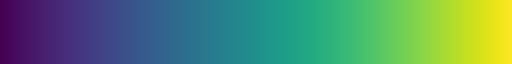

In [240]:
cmap

In [241]:
road_near_bike_members_df = duckdb.sql("""SELECT * 
FROM (SELECT * REPLACE(ST_AsText(grid_cell) as grid_cell)
FROM grid g 
LEFT JOIN road_near_bike_members_stats_per_grid s 
ON g.grid_id = s.grid_id
) as joined
WHERE percent_with_bike_path > 5
""").df()

road_near_bike_members_gdf = gpd.GeoDataFrame(road_near_bike_members_df, geometry=road_near_bike_members_df["grid_cell"].apply(wkt.loads), crs="EPSG:4326")

cmap_values = road_near_bike_members_gdf['percent_with_bike_path'].fillna(0)
cmap_values_norm = (cmap_values - cmap_values.min()) / (cmap_values.max() - cmap_values.min())

cmap = plt.get_cmap("viridis") 

road_near_bike_members_layer = PolygonLayer.from_geopandas(road_near_bike_members_gdf, get_fill_color = apply_continuous_cmap(cmap_values_norm, cmap=cmap), get_line_width=1, get_line_color='black', opacity=0.5, visible=True)

Map(road_near_bike_members_layer)